<a href="https://colab.research.google.com/github/dmbk/Anomaly-Detection-System/blob/master/TEST_AAE_ROC_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install imageio
!pip install qpsolvers
!pip install shapely 
#!pip install tensorflow_datasets
!pip install keras-layer-normalization
from google.colab import drive
#!pip install alive-progress
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [0]:


from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import skimage
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from os.path import join
from os import listdir
from os.path import isfile, join, isdir

#import keras
import argparse
from os.path import dirname
import cv2
from google.colab.patches import cv2_imshow
	
import statistics
import shutil

import matplotlib.pyplot as plt

import time
#from progress.bar import IncrementalBar

import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, Dropout, Activation, InputLayer
from keras.optimizers import Adam
from keras_layer_normalization import LayerNormalization
from keras.models import load_model
import csv
from scipy.interpolate import make_interp_spline, BSpline

from scipy.signal import savgol_filter

In [0]:
def get_single_test(single_test_path):
    
    sz = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == "tif":
          sz = sz +1
    test = np.zeros(shape=(sz, conf.dim2, conf.dim3, conf.dim4))
    cnt = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == "tif":
            #print("img path: "+join(single_test_path, f))
            img = Image.open(join(single_test_path, f)).resize((conf.dim2, conf.dim3))
            #cv2_imshow(np.array(img,dtype=np.float32))
            #cv2.waitKey(0)
            img = np.array(img, dtype=np.float32) / 256
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

def get_test_sequences(test_case_dir):
    test = get_single_test(join(conf.TEST_DIR,test_case_dir))
    print("Test case loaded")
    sz = test.shape[0] - conf.dim1
    sequences = np.zeros((sz, conf.dim1, conf.dim2, conf.dim3, conf.dim4))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim1, conf.dim2, conf.dim3, conf.dim4))
        for j in range(0, conf.dim1):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip
    return sequences





In [0]:
class Config:
    def __init__(self, data_dir_, cwdir_name_, data_set):
        self.data_set_name = data_set
        self.data_dir = data_dir_
        self.data_set_dir = join(self.data_dir, data_set)
        self.cwdir_name = cwdir_name_
        self.cwdir = join(self.data_dir,self.cwdir_name)
        self.run_data = join(self.cwdir, "training_dir")
        self.image_dir = join(self.run_data,self.data_set_name,"Test/")
        if not os.path.exists(self.cwdir):
            os.mkdir(self.cwdir)
            os.mkdir(self.run_data)
    
        if not os.path.exists(self.run_data):
            #shutil.rmtree(self.run_data)
            os.mkdir(self.run_data)
            os.makedirs(self.image_dir, exist_ok=True)

        self.DATASET_PATH = join(self.data_set_dir,"Train/")
        self.TEST_DIR = join(self.data_set_dir,"Test/")
        self.BATCH_SIZE = 2
        self.EPOCHS = 50
        self.GEN_MODEL_PATH = join(self.cwdir,"model_gen_Conv2DLSTM_AAE")
        self.DIS_MODEL_PATH = join(self.cwdir,"model_dis_Conv2DLSTM_AAE")
        self.DEC_MODEL_PATH = join(self.cwdir,"model_dec_Conv2DLSTM_AAE")

        self.retrain = 0
        self.dim1 = 10
        self.dim2 = 256
        self.dim3 = 256
        self.dim4 = 1
        self.latent_dim = 327680


    def reconfig(self, new_name, batch_size = 4, epochs = 5, retrain = 0):
        self.cwdir_name = new_name
        self.cwdir = join(self.data_dir, self.cwdir_name)
        self.run_data = join(self.cwdir, "training_dir")
        self.image_dir = join(self.run_data,self.data_set_name,"Test/")

        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.GEN_MODEL_PATH = join(self.cwdir,"model_gen_Conv2DLSTM_AAE")
        self.DIS_MODEL_PATH = join(self.cwdir,"model_dis_Conv2DLSTM_AAE")
        self.DEC_MODEL_PATH = join(self.cwdir,"model_dec_Conv2DLSTM_AAE")

        self.retrain = retrain
        if retrain == 0:
            print("Configuring train from scratch")
            if not os.path.exists(self.cwdir):
                os.mkdir(self.cwdir)
                os.mkdir(self.run_data)
    
            if os.path.exists(self.run_data):
                shutil.rmtree(self.run_data)
                os.mkdir(self.run_data)
                os.makedirs(self.image_dir, exist_ok=True)


conf = Config(data_dir_="/content/drive/My Drive/", cwdir_name_="Conv2DLSTM_AAE_PED1", data_set="UCSD_Anomaly_Dataset.v1p2/UCSDped1/") 


In [0]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/content/drive/My Drive/Persistence1D/python')


import matplotlib.pyplot as plt
import numpy as np
from persistence1d import RunPersistence
from reconstruct1d import RunReconstruction


from shapely.geometry import LineString

In [0]:
TestVideoFile_ped1 = list((36,2))
TestVideoFile_ped1 = [[60,152], [50,175], [91,200], [31,168], [5,90], [1,100], [1,175], [1,94], [1,48], [1,140],   [70,165],   [130,200],   [1,156],   [1,200],   [138,200],   [123,200],   [1,47],   [54,120],    [64,138],    [45,175],    [31,200],    [16,107],    [8,165],    [50,171],    [40,135],    [77,144],    [10,122],    [105,200],    [1,15],    [175,200],    [1,180],    [1,52],  [5,165],    [1,121],    [86,200],   [15,108]]




def SortExtremaByPersistence(ExtremaAndPersistence):
    #~ Sort the list of extrema by persistence.
    #~ The original list from RunPersistence() is not guaranteed to be sorted,
    #~ although it may appear sorted in many cases.
    #~ This call to sorted() creates a new list. If you want to sort in-place, use ExtremaAndPersistence.sort()
    SortedExtremaAndPersistence = sorted(ExtremaAndPersistence, key=lambda ExtremumAndPersistence: ExtremumAndPersistence[0])
    return SortedExtremaAndPersistence

def GetMinima(ExtremaAndPersistence):
    Minima = [t for t in ExtremaAndPersistence[::2]]
    return Minima

def GetMaxima(ExtremaAndPersistence):
    Maxima = [t for t in ExtremaAndPersistence[1::2]]
    return Maxima


def GetIntersection(x, f, g):

    plt.plot(x, f)
    plt.plot(x, g)

    first_line = LineString(np.column_stack((x, f)))
    second_line = LineString(np.column_stack((x, g)))
    intersection = first_line.intersection(second_line)

    if intersection.geom_type == 'MultiPoint':
        plt.plot(*LineString(intersection).xy, 'o')
    elif intersection.geom_type == 'Point':
        plt.plot(*intersection.xy, 'o')


def persistence(InputData, dt, id, color, threshold_abs):
    #~ Compute the extrema of the given data and their persistence.
    ExtremaAndPersistence = RunPersistence(InputData)

    #~ Keep only those extrema with a persistence larger than 0.5.
    FilteredIndices = [t[0] for t in ExtremaAndPersistence if t[1] >= 0.1]

    #~ This simple call is all you need to reconstruct a smooth function containing only the filtered extrema
    SmoothData = RunReconstruction(InputData, FilteredIndices, 'biharmonic', 0.0000001)
    #print("Smooth data ")
    #print(SmoothData)

    x = np.array([x for x in range(0, InputData.shape[0])])
    f = np.ones(x.shape[0])*threshold_abs
    g = SmoothData
    GetIntersection(x, f, g)
    #~ Plot original and smoothed data
    fig, ax = plt.subplots()
    ax.plot(range(0, len(InputData)), InputData, label="Original Data")
    ax.plot(range(0, len(SmoothData)), SmoothData, label="Smooth Data")
    ExtremaIndices = [t[0] for t in ExtremaAndPersistence]
    sorted_extr = SortExtremaByPersistence(ExtremaAndPersistence)
    minima = SortExtremaByPersistence(GetMinima(ExtremaAndPersistence))
    maxima = SortExtremaByPersistence(GetMaxima(ExtremaAndPersistence))
    print("###########Print All Extremas#################")

    print([t for t in ExtremaAndPersistence])

    print("###########Print Filtered Extremas#################")

    print([t for t in FilteredIndices])

    print("###########Print Sorted Extremas#################")

    print([t for t in sorted_extr])

    print("###########Print Minimas#################")

    print([t for t in minima])

    print("###########Print Maximas#################")

    print([t for t in maxima])


    ax.plot(ExtremaIndices, InputData[ExtremaIndices], marker='.', linestyle='')
    ax.plot(FilteredIndices, InputData[FilteredIndices], marker='*', linestyle='')
    ax.set(xlabel='data index', ylabel='data value')
    #ax.set_aspect(1.0/ax.get_data_ratio()*0.2)
    plt.axvspan(TestVideoFile_ped1[id-1][0], TestVideoFile_ped1[id-1][1], alpha=0.5, color=color)
    #plt.axhline(y=threshold_abs,linewidth=1, color='blue') 

    if dt == 1 and id == 5:
        plt.axvspan(140, 200, alpha=0.5, color=color)
    elif dt == 1 and id == 6:
        plt.axvspan(110, 200, alpha=0.5, color=color) 
    elif dt == 1 and id == 29:
        plt.axvspan(45, 113, alpha=0.5, color=color)
    elif dt == 1 and id == 32:
        plt.axvspan(65, 115, alpha=0.5, color=color)

    ax.grid()
    #ax.plot()

    plt.legend()    
    plt.show()

threshold = 0.9
def fill_gt_ped1(sr, id, color, threshold_abs):
    #plt.xlim((conf.dim1,len(sr)+conf.dim1))
    sr = np.reshape(sr, (sr.shape[0],))
    print(sr.shape)
    #zeros = np.zeros((conf.dim1,))
    #print(zeros.shape)
    #plt.plot(np.concatenate((zeros, sr)))
    persistence(sr, 1, id, color, threshold_abs)
    yhat = savgol_filter(sr, 51, 3)
    persistence(yhat, 1, id, color, threshold_abs)
    #plt.plot(sr)  
    return 

    #plt.plot(yhat, color='red')
    plt.axvspan(TestVideoFile_ped1[id-1][0], TestVideoFile_ped1[id-1][1], alpha=0.5, color=color)
    #plt.axhline(y=threshold_abs,linewidth=1, color='blue')
    if id == 5:
        plt.axvspan(140, 200, alpha=0.5, color=color)
    elif id == 6:
        plt.axvspan(110, 200, alpha=0.5, color=color) 
    elif id == 29:
        plt.axvspan(45, 113, alpha=0.5, color=color)
    elif id == 32:
        plt.axvspan(65, 115, alpha=0.5, color=color)


    plt.ylabel('regularity score sr_ae(t)')
    plt.xlabel('frame t')
    plt.show()



TestVideoFile_ped2 = list((12,2))
TestVideoFile_ped2 = [[61,180],[95,180],[1,146],[31,180],[1,129],[1,159],[46,180],[1,180],[1,120],[1,150],[1,180],[88,180]]

def fill_gt_ped2(sr, id, color, threshold_abs):
    #plt.xlim((conf.dim1,len(sr)+conf.dim1))
    sr = np.reshape(sr, (sr.shape[0],))
    #plt.plot(np.concatenate((np.zeros((conf.dim1,)), sr)))
    persistence(sr, 2, id, color, threshold_abs)
    yhat = savgol_filter(sr, 51, 3)
    persistence(yhat, 2, id, color, threshold_abs)
    return 

    #plt.plot(sr)

    #plt.plot(yhat, color='red')
    plt.axvspan(TestVideoFile_ped2[id-1][0], TestVideoFile_ped2[id-1][1], alpha=0.5, color=color)
    #plt.axhline(y=threshold_abs,linewidth=1, color='blue')
    plt.ylabel('regularity score sr_ae(t)')
    plt.xlabel('frame t')
    plt.show()



/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization_9 (Layer (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_10 (Laye (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_11 (Laye (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, 10, 32, 32, 32)   

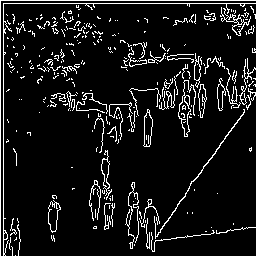

Test case loaded
Test001 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(94, 0.0005862650241179601), (95, 0.0005862650241179601), (90, 0.01998747033675541), (91, 0.01998747033675541), (112, 0.0014004497023626383), (113, 0.0014004497023626383), (110, 0.0025604113058220745), (111, 0.0025604113058220745), (83, 0.005859688104315808), (85, 0.005859688104315808), (115, 0.02653327842646591), (108, 0.02653327842646591), (136, 1.3042629724902e-05), (137, 1.3042629724902e-05), (78, 0.031745486137348955), (80, 0.031745486137348955), (71, 0.006207047804801635), (72, 0.006207047804801635), (122, 0.0003998987071269777), (121, 0.0003998987071269777), (66, 0.006326630054928506), (63, 0.006326630054928506), (54, 0.057816055694999924), (67, 0.057816055694999924), (129, 0.004121239702880475), (131, 0.004121239702880475), (127, 0.0037652010681388237), (125, 0.0037652010681388237), (138, 0.04308038075270537), (128, 0.04308038075270537), (14

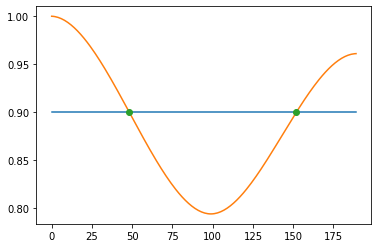

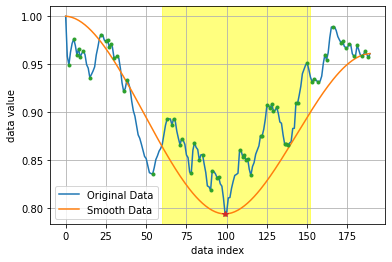

###########Print All Extremas#################
[(72, 1.4960245932615912e-05), (71, 1.4960245932615912e-05), (58, 0.0065958396079751624), (74, 0.0065958396079751624), (11, 0.002596915316170567), (22, 0.002596915316170567), (189, 0.01461497000425771), (172, 0.01461497000425771), (101, inf)]
###########Print Filtered Extremas#################
[101]
###########Print Sorted Extremas#################
[(11, 0.002596915316170567), (22, 0.002596915316170567), (58, 0.0065958396079751624), (71, 1.4960245932615912e-05), (72, 1.4960245932615912e-05), (74, 0.0065958396079751624), (101, inf), (172, 0.01461497000425771), (189, 0.01461497000425771)]
###########Print Minimas#################
[(11, 0.002596915316170567), (58, 0.0065958396079751624), (72, 1.4960245932615912e-05), (101, inf), (189, 0.01461497000425771)]
###########Print Maximas#################
[(22, 0.002596915316170567), (71, 1.4960245932615912e-05), (74, 0.0065958396079751624), (172, 0.01461497000425771)]


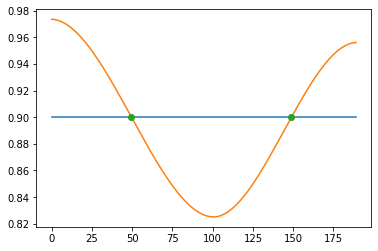

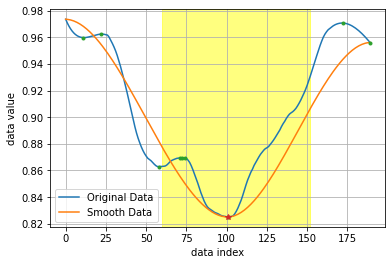

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(140, 0.008985894695929919), (141, 0.008985894695929919), (102, 0.0007775745163693948), (101, 0.0007775745163693948), (90, 0.0005134941392624937), (89, 0.0005134941392624937), (136, 0.008228429035106344), (137, 0.008228429035106344), (106, 0.0013560597899940907), (105, 0.0013560597899940907), (94, 0.00026909256948515203), (95, 0.00026909256948515203), (46, 0.0046075592271485055), (48, 0.0046075592271485055), (146, 0.015652507709455254), (145, 0.015652507709455254), (75, 0.0002658507300419277), (76, 0.0002658507300419277), (117, 0.0012132662045255538), (116, 0.0012132662045255538), (88, 0.018677693234214088), (91, 0.018677693234214088), (57, 0.002009100012102527), (56, 0.002009100012102527), (133, 0.0002653291061990304), (134, 0.0002653291061990304), (110, 0.006499408373733417), (109, 0.006499408373733417), (115, 0.010534845469598708), (113, 0.010534845469598708), (71, 0.0041694373565190

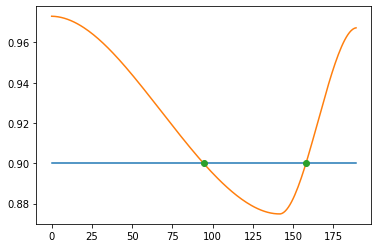

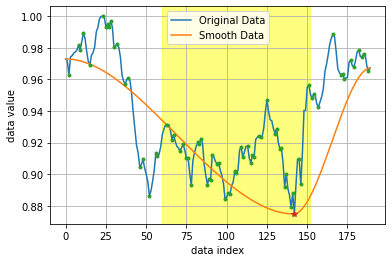

###########Print All Extremas#################
[(138, 2.655446094435021e-05), (139, 2.655446094435021e-05), (134, 1.1930649652658332e-06), (135, 1.1930649652658332e-06), (59, 0.008605934415498617), (75, 0.008605934415498617), (140, 0.011381419208509547), (121, 0.011381419208509547), (184, 0.0013474967515565428), (173, 0.0013474967515565428), (0, 0.02219205562779958), (22, 0.02219205562779958), (100, inf)]
###########Print Filtered Extremas#################
[100]
###########Print Sorted Extremas#################
[(0, 0.02219205562779958), (22, 0.02219205562779958), (59, 0.008605934415498617), (75, 0.008605934415498617), (100, inf), (121, 0.011381419208509547), (134, 1.1930649652658332e-06), (135, 1.1930649652658332e-06), (138, 2.655446094435021e-05), (139, 2.655446094435021e-05), (140, 0.011381419208509547), (173, 0.0013474967515565428), (184, 0.0013474967515565428)]
###########Print Minimas#################
[(0, 0.02219205562779958), (59, 0.008605934415498617), (100, inf), (134, 1.1930

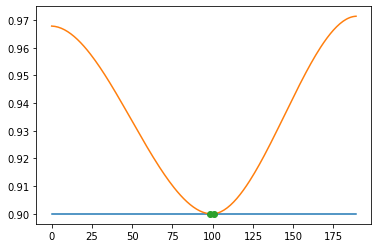

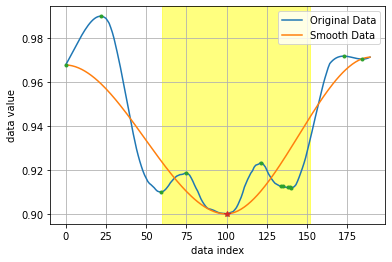

BGS show


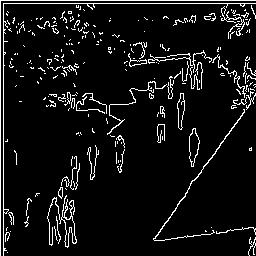

Test case loaded
Test002 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(60, 0.017800629114462452), (62, 0.017800629114462452), (69, 0.0034884219676643013), (68, 0.0034884219676643013), (142, 0.004577892218139201), (143, 0.004577892218139201), (74, 0.00983768126179474), (72, 0.00983768126179474), (139, 0.001397749191347275), (140, 0.001397749191347275), (135, 0.02379189705967022), (138, 0.02379189705967022), (80, 0.005999223573169288), (79, 0.005999223573169288), (130, 0.006949357006269086), (132, 0.006949357006269086), (127, 0.005295362890986199), (128, 0.005295362890986199), (160, 0.03605590782192114), (155, 0.03605590782192114), (168, 0.0008185847543109581), (167, 0.0008185847543109581), (170, 0.006245113920828382), (169, 0.006245113920828382), (119, 0.01807885288420874), (122, 0.01807885288420874), (173, 0.0007948183989407998), (172, 0.0007948183989407998), (113, 0.0009430245042703067), (112, 0.0009430245042703067),

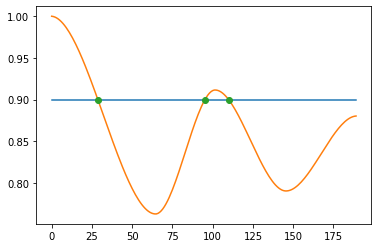

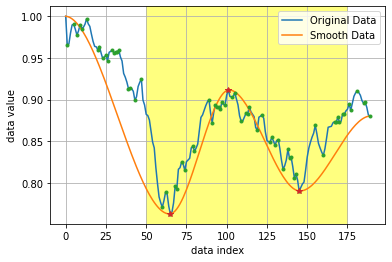

###########Print All Extremas#################
[(189, 0.010582768738155002), (181, 0.010582768738155002), (145, 0.07686392950384746), (101, 0.07686392950384746), (0, 0.00224162797749361), (5, 0.00224162797749361), (67, inf)]
###########Print Filtered Extremas#################
[67]
###########Print Sorted Extremas#################
[(0, 0.00224162797749361), (5, 0.00224162797749361), (67, inf), (101, 0.07686392950384746), (145, 0.07686392950384746), (181, 0.010582768738155002), (189, 0.010582768738155002)]
###########Print Minimas#################
[(0, 0.00224162797749361), (67, inf), (145, 0.07686392950384746), (189, 0.010582768738155002)]
###########Print Maximas#################
[(5, 0.00224162797749361), (101, 0.07686392950384746), (181, 0.010582768738155002)]


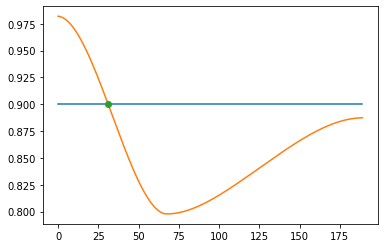

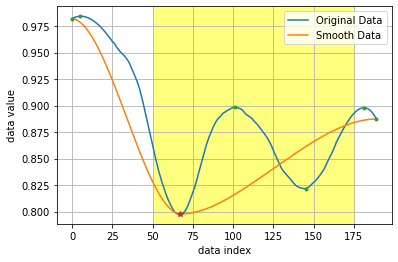

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(62, 0.007796071246931269), (64, 0.007796071246931269), (65, 0.012747057900099223), (60, 0.012747057900099223), (145, 0.004073066152008087), (143, 0.004073066152008087), (142, 0.007434486236037374), (147, 0.007434486236037374), (139, 0.0007936641814394463), (140, 0.0007936641814394463), (131, 0.0001630380444884727), (130, 0.0001630380444884727), (127, 0.010956799639678438), (132, 0.010956799639678438), (135, 0.01954211001160644), (138, 0.01954211001160644), (71, 0.0019161212630602886), (70, 0.0019161212630602886), (74, 0.007068418581808955), (72, 0.007068418581808955), (119, 0.01951517335329711), (122, 0.01951517335329711), (79, 0.0063960825813335065), (76, 0.0063960825813335065), (159, 0.0077273736191428855), (155, 0.0077273736191428855), (166, 0.006694563788957164), (169, 0.006694563788957164), (113, 0.003323532253353023), (114, 0.003323532253353023), (170, 0.012762577731951108), (163

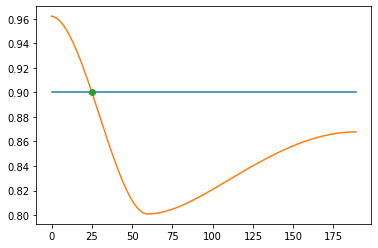

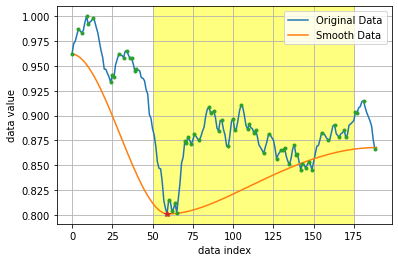

###########Print All Extremas#################
[(93, 8.192479895086091e-05), (94, 8.192479895086091e-05), (138, 0.03943869088340646), (90, 0.03943869088340646), (189, 0.022791558191691208), (177, 0.022791558191691208), (63, inf)]
###########Print Filtered Extremas#################
[63]
###########Print Sorted Extremas#################
[(63, inf), (90, 0.03943869088340646), (93, 8.192479895086091e-05), (94, 8.192479895086091e-05), (138, 0.03943869088340646), (177, 0.022791558191691208), (189, 0.022791558191691208)]
###########Print Minimas#################
[(63, inf), (93, 8.192479895086091e-05), (138, 0.03943869088340646), (189, 0.022791558191691208)]
###########Print Maximas#################
[(90, 0.03943869088340646), (94, 8.192479895086091e-05), (177, 0.022791558191691208)]


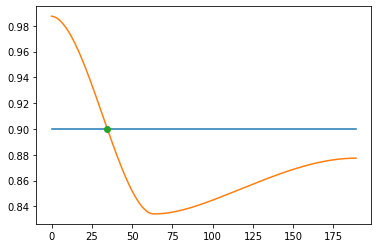

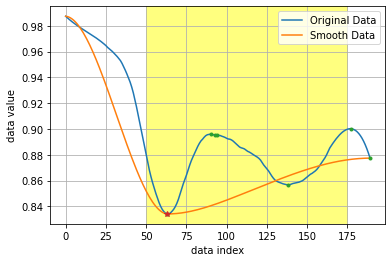

BGS show


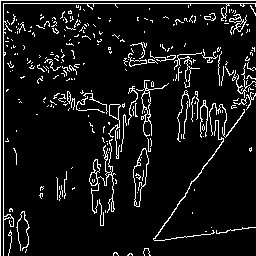

Test case loaded
Test003 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(182, 0.006601774539054639), (185, 0.006601774539054639), (167, 0.0012123907604442152), (168, 0.0012123907604442152), (163, 0.0017675822846802136), (165, 0.0017675822846802136), (169, 0.029812004905650058), (159, 0.029812004905650058), (153, 0.05450277958013672), (175, 0.05450277958013672), (129, 0.0012271848942837504), (130, 0.0012271848942837504), (137, 0.00151958469536706), (135, 0.00151958469536706), (112, 0.0010652245031135266), (113, 0.0010652245031135266), (132, 0.03111190673830455), (139, 0.03111190673830455), (116, 0.03775950162343977), (121, 0.03775950162343977), (99, 0.03790435936297232), (104, 0.03790435936297232), (75, 1.8254404496875765e-06), (76, 1.8254404496875765e-06), (83, 0.004608070155330379), (85, 0.004608070155330379), (79, 0.06320114091087559), (81, 0.06320114091087559), (48, 0.0012979190032704757), (49, 0.0012979190032704757)

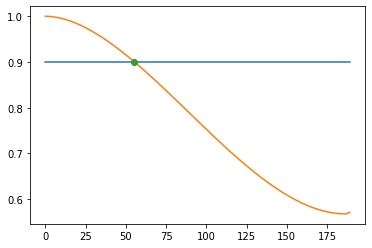

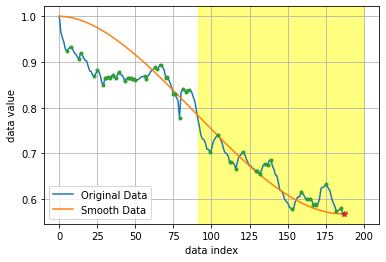

###########Print All Extremas#################
[(161, 0.012953425021902776), (174, 0.012953425021902776), (65, 0.00026868748764508066), (68, 0.00026868748764508066), (39, 0.015696646214277243), (54, 0.015696646214277243), (189, inf)]
###########Print Filtered Extremas#################
[189]
###########Print Sorted Extremas#################
[(39, 0.015696646214277243), (54, 0.015696646214277243), (65, 0.00026868748764508066), (68, 0.00026868748764508066), (161, 0.012953425021902776), (174, 0.012953425021902776), (189, inf)]
###########Print Minimas#################
[(39, 0.015696646214277243), (65, 0.00026868748764508066), (161, 0.012953425021902776), (189, inf)]
###########Print Maximas#################
[(54, 0.015696646214277243), (68, 0.00026868748764508066), (174, 0.012953425021902776)]


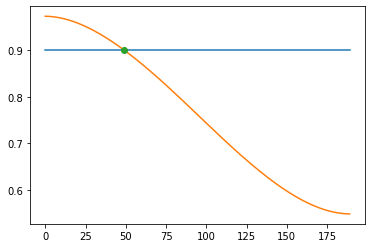

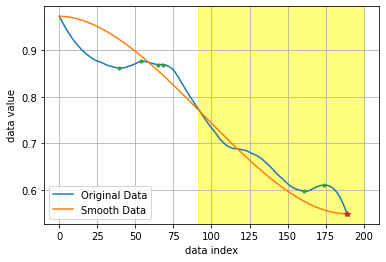

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(189, 0.009111596028476998), (185, 0.009111596028476998), (151, 0.00013630878946169211), (153, 0.00013630878946169211), (162, 0.004382581092916449), (164, 0.004382581092916449), (158, 0.0048720547801313074), (159, 0.0048720547801313074), (154, 0.013972233243568999), (157, 0.013972233243568999), (146, 0.0011538270748026047), (147, 0.0011538270748026047), (167, 0.026911009594434265), (172, 0.026911009594434265), (140, 0.000954227156644949), (141, 0.000954227156644949), (125, 0.009506089525411876), (128, 0.009506089525411876), (137, 0.0007313284465332304), (138, 0.0007313284465332304), (132, 0.01969815634686123), (136, 0.01969815634686123), (112, 0.002234422020616189), (113, 0.002234422020616189), (116, 0.012629484469096619), (118, 0.012629484469096619), (110, 0.00038018969413733394), (111, 0.00038018969413733394), (100, 0.002027497686651003), (102, 0.002027497686651003), (103, 0.007568616

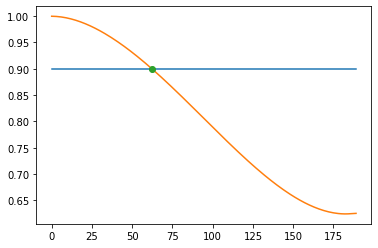

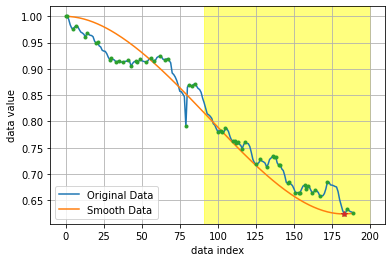

###########Print All Extremas#################
[(164, 0.0013246700304956338), (169, 0.0013246700304956338), (42, 0.00993656965458567), (54, 0.00993656965458567), (189, inf)]
###########Print Filtered Extremas#################
[189]
###########Print Sorted Extremas#################
[(42, 0.00993656965458567), (54, 0.00993656965458567), (164, 0.0013246700304956338), (169, 0.0013246700304956338), (189, inf)]
###########Print Minimas#################
[(42, 0.00993656965458567), (164, 0.0013246700304956338), (189, inf)]
###########Print Maximas#################
[(54, 0.00993656965458567), (169, 0.0013246700304956338)]


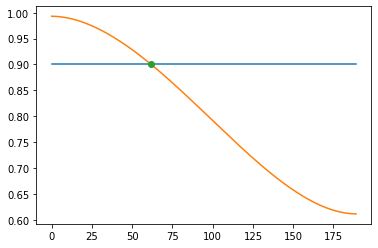

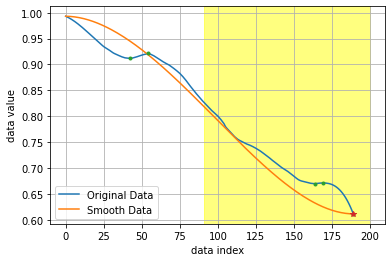

BGS show


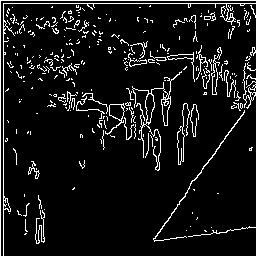

Test case loaded
Test004 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(52, 0.0009574846420359329), (51, 0.0009574846420359329), (16, 0.0057091883241061625), (15, 0.0057091883241061625), (50, 0.005235129460083643), (49, 0.005235129460083643), (7, 0.006362318882998652), (9, 0.006362318882998652), (22, 0.017528062023764113), (19, 0.017528062023764113), (3, 0.010465277325069744), (5, 0.010465277325069744), (37, 0.014594971952899827), (39, 0.014594971952899827), (55, 0.0008406073863693742), (54, 0.0008406073863693742), (63, 5.176127883987913e-05), (62, 5.176127883987913e-05), (61, 0.007749425753486916), (59, 0.007749425753486916), (27, 0.002066095758009978), (26, 0.002066095758009978), (31, 0.003040022653890917), (32, 0.003040022653890917), (12, 0.06135580514569294), (28, 0.06135580514569294), (76, 0.004673407184158762), (74, 0.004673407184158762), (72, 0.018327876090965645), (69, 0.018327876090965645), (137, 0.00246030910

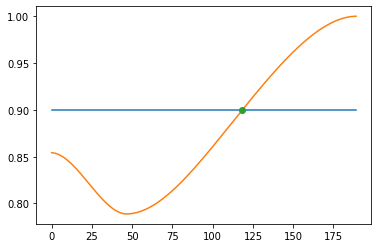

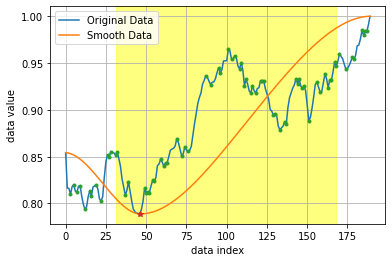

###########Print All Extremas#################
[(49, 0.013910399030056086), (26, 0.013910399030056086), (133, 0.00017178419312546822), (135, 0.00017178419312546822), (137, 0.045620527571995084), (102, 0.045620527571995084), (10, inf)]
###########Print Filtered Extremas#################
[10]
###########Print Sorted Extremas#################
[(10, inf), (26, 0.013910399030056086), (49, 0.013910399030056086), (102, 0.045620527571995084), (133, 0.00017178419312546822), (135, 0.00017178419312546822), (137, 0.045620527571995084)]
###########Print Minimas#################
[(10, inf), (49, 0.013910399030056086), (133, 0.00017178419312546822), (137, 0.045620527571995084)]
###########Print Maximas#################
[(26, 0.013910399030056086), (102, 0.045620527571995084), (135, 0.00017178419312546822)]


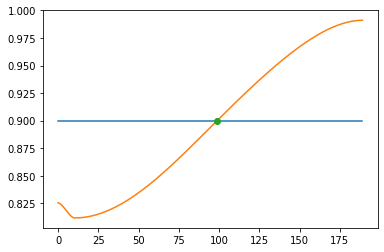

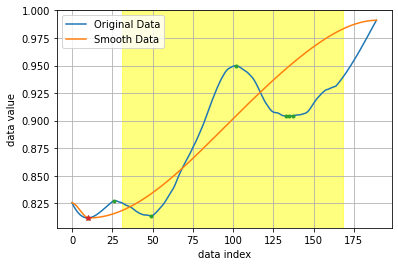

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(42, 0.00030845374744958853), (43, 0.00030845374744958853), (35, 0.0009824797580206823), (36, 0.0009824797580206823), (3, 0.00795490317465275), (2, 0.00795490317465275), (33, 0.002355112753338884), (34, 0.002355112753338884), (37, 0.011390096148870654), (39, 0.011390096148870654), (12, 0.010959905517730073), (19, 0.010959905517730073), (31, 0.0018943564910244293), (32, 0.0018943564910244293), (6, 0.003314082150737141), (5, 0.003314082150737141), (0, 0.025196719872969342), (9, 0.025196719872969342), (44, 0.02120562151893135), (29, 0.02120562151893135), (50, 0.00041750921963090715), (49, 0.00041750921963090715), (63, 0.0017810851892318125), (62, 0.0017810851892318125), (55, 0.0038512407371920077), (53, 0.0038512407371920077), (59, 4.376969972785805e-05), (60, 4.376969972785805e-05), (61, 0.007023331497620577), (57, 0.007023331497620577), (72, 0.012588040645364118), (69, 0.0125880406453641

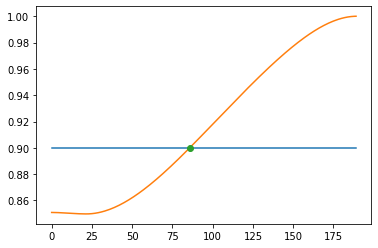

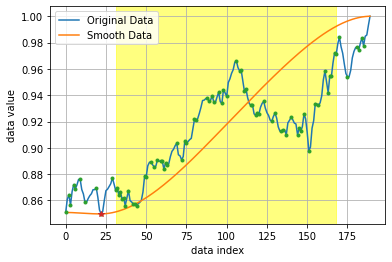

###########Print All Extremas#################
[(32, 3.292237918151031e-05), (31, 3.292237918151031e-05), (30, 0.005742452153680078), (13, 0.005742452153680078), (137, 0.00013336683113884806), (138, 0.00013336683113884806), (144, 0.03458418756245529), (102, 0.03458418756245529), (189, 0.0006054719059295222), (187, 0.0006054719059295222), (0, inf)]
###########Print Filtered Extremas#################
[0]
###########Print Sorted Extremas#################
[(0, inf), (13, 0.005742452153680078), (30, 0.005742452153680078), (31, 3.292237918151031e-05), (32, 3.292237918151031e-05), (102, 0.03458418756245529), (137, 0.00013336683113884806), (138, 0.00013336683113884806), (144, 0.03458418756245529), (187, 0.0006054719059295222), (189, 0.0006054719059295222)]
###########Print Minimas#################
[(0, inf), (30, 0.005742452153680078), (32, 3.292237918151031e-05), (137, 0.00013336683113884806), (144, 0.03458418756245529), (189, 0.0006054719059295222)]
###########Print Maximas#################


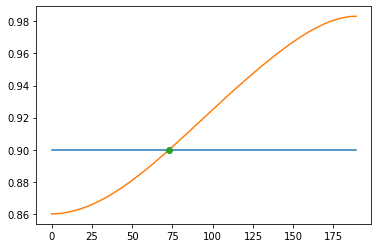

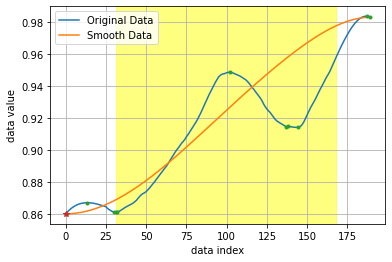

BGS show


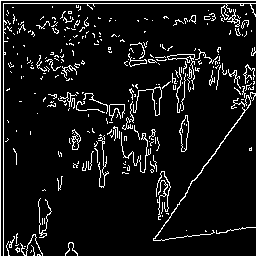

Test case loaded
Test005 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(142, 0.003537016304037799), (140, 0.003537016304037799), (136, 0.00031777010401268235), (138, 0.00031777010401268235), (175, 0.0014634205689347812), (176, 0.0014634205689347812), (177, 0.00735805647835952), (173, 0.00735805647835952), (151, 0.0006996555966137796), (152, 0.0006996555966137796), (185, 0.00020741336509910724), (184, 0.00020741336509910724), (172, 0.0129414543897588), (179, 0.0129414543897588), (148, 0.011313976051303576), (146, 0.011313976051303576), (153, 0.011270946020968564), (150, 0.011270946020968564), (189, 0.011334289186243018), (187, 0.011334289186243018), (126, 0.0028947079646896023), (128, 0.0028947079646896023), (181, 0.06411107203325106), (163, 0.06411107203325106), (114, 0.004196420352924779), (113, 0.004196420352924779), (116, 0.0037317419967719534), (115, 0.0037317419967719534), (32, 0.0002773065433783195), (33, 0.00027

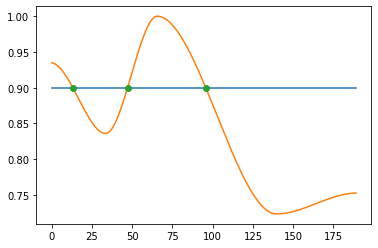

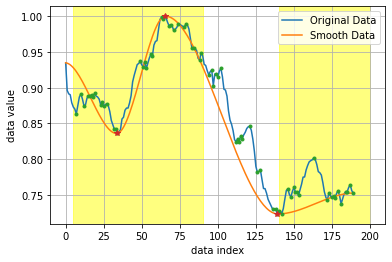

###########Print All Extremas#################
[(184, 0.024236010132755226), (161, 0.024236010132755226), (0, 0.008672206590153553), (7, 0.008672206590153553), (71, 0.00010207266923023539), (70, 0.00010207266923023539), (25, 0.12369192268394313), (72, 0.12369192268394313), (142, inf)]
###########Print Filtered Extremas#################
[25, 72, 142]
###########Print Sorted Extremas#################
[(0, 0.008672206590153553), (7, 0.008672206590153553), (25, 0.12369192268394313), (70, 0.00010207266923023539), (71, 0.00010207266923023539), (72, 0.12369192268394313), (142, inf), (161, 0.024236010132755226), (184, 0.024236010132755226)]
###########Print Minimas#################
[(0, 0.008672206590153553), (25, 0.12369192268394313), (71, 0.00010207266923023539), (142, inf), (184, 0.024236010132755226)]
###########Print Maximas#################
[(7, 0.008672206590153553), (70, 0.00010207266923023539), (72, 0.12369192268394313), (161, 0.024236010132755226)]


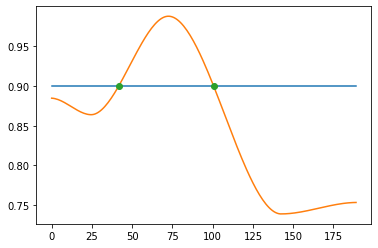

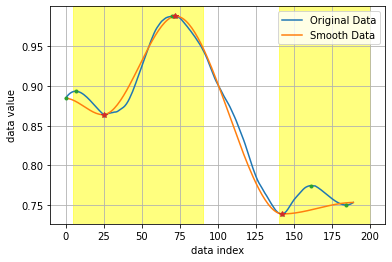

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(177, 0.0007774539000325875), (176, 0.0007774539000325875), (151, 0.0005774072603630387), (152, 0.0005774072603630387), (181, 0.006144382060792153), (179, 0.006144382060792153), (153, 0.009455152056288552), (150, 0.009455152056288552), (148, 0.011175869571688146), (146, 0.011175869571688146), (189, 0.006536897770831107), (186, 0.006536897770831107), (161, 0.0028083373729488326), (159, 0.0028083373729488326), (164, 0.0008158457374974892), (165, 0.0008158457374974892), (172, 0.036638743725795564), (163, 0.036638743725795564), (126, 0.013237828841207944), (128, 0.013237828841207944), (118, 0.004693157325164621), (119, 0.004693157325164621), (114, 0.001984593497205589), (115, 0.001984593497205589), (31, 0.005106796619925857), (32, 0.005106796619925857), (112, 0.0015846386527477163), (113, 0.0015846386527477163), (38, 0.005100732210623904), (37, 0.005100732210623904), (15, 0.0024441157847715

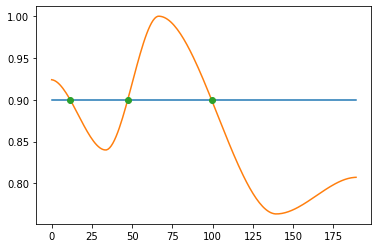

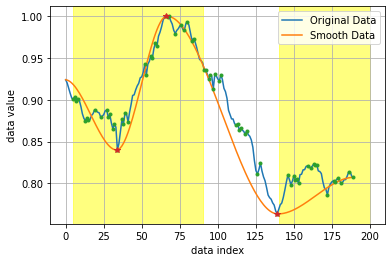

###########Print All Extremas#################
[(179, 0.01204543690337434), (163, 0.01204543690337434), (27, 0.12058151733459332), (72, 0.12058151733459332), (141, inf)]
###########Print Filtered Extremas#################
[27, 72, 141]
###########Print Sorted Extremas#################
[(27, 0.12058151733459332), (72, 0.12058151733459332), (141, inf), (163, 0.01204543690337434), (179, 0.01204543690337434)]
###########Print Minimas#################
[(27, 0.12058151733459332), (141, inf), (179, 0.01204543690337434)]
###########Print Maximas#################
[(72, 0.12058151733459332), (163, 0.01204543690337434)]


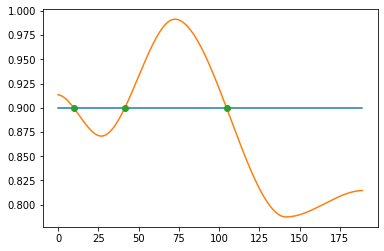

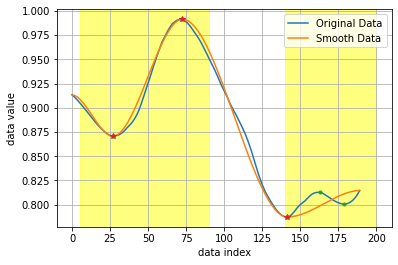

BGS show


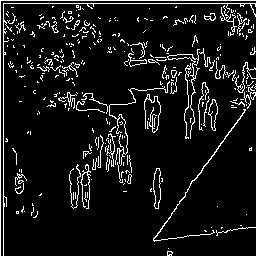

Test case loaded
Test006 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(3, 0.0006272743057776919), (2, 0.0006272743057776919), (33, 0.0015120516949166385), (34, 0.0015120516949166385), (28, 0.003664726206283997), (27, 0.003664726206283997), (24, 0.0162669957698498), (30, 0.0162669957698498), (41, 0.010130054198731475), (38, 0.010130054198731475), (67, 0.010207967655289973), (69, 0.010207967655289973), (77, 0.004321425402594725), (78, 0.004321425402594725), (79, 0.010633382298274152), (74, 0.010633382298274152), (115, 0.0008766337374216393), (116, 0.0008766337374216393), (35, 0.08773765464419336), (14, 0.08773765464419336), (52, 0.0024911932972262463), (51, 0.0024911932972262463), (174, 0.0045273283445411705), (172, 0.0045273283445411705), (58, 0.006086785187466082), (60, 0.006086785187466082), (133, 0.001997049478348112), (134, 0.001997049478348112), (138, 0.0033756951144992), (137, 0.0033756951144992), (186, 0.0017528

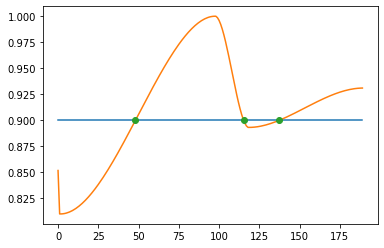

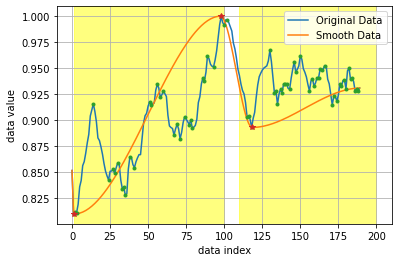

###########Print All Extremas#################
[(34, 0.03021214184857579), (14, 0.03021214184857579), (73, 0.011759783664030077), (58, 0.011759783664030077), (148, 0.00021757749389639258), (150, 0.00021757749389639258), (154, 0.0008937264681181389), (158, 0.0008937264681181389), (179, 0.012278390870750555), (140, 0.012278390870750555), (126, 0.045243497031235314), (97, 0.045243497031235314), (0, inf)]
###########Print Filtered Extremas#################
[0]
###########Print Sorted Extremas#################
[(0, inf), (14, 0.03021214184857579), (34, 0.03021214184857579), (58, 0.011759783664030077), (73, 0.011759783664030077), (97, 0.045243497031235314), (126, 0.045243497031235314), (140, 0.012278390870750555), (148, 0.00021757749389639258), (150, 0.00021757749389639258), (154, 0.0008937264681181389), (158, 0.0008937264681181389), (179, 0.012278390870750555)]
###########Print Minimas#################
[(0, inf), (34, 0.03021214184857579), (73, 0.011759783664030077), (126, 0.045243497031235

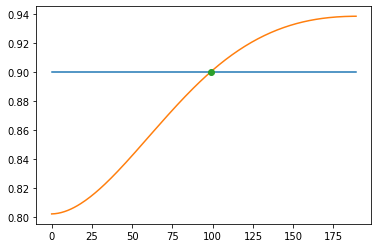

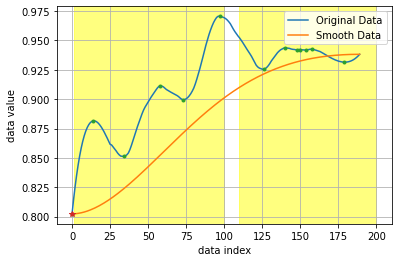

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(2, 0.0030768632000695018), (1, 0.0030768632000695018), (4, 0.006934221028039422), (3, 0.006934221028039422), (33, 0.003623173903945953), (34, 0.003623173903945953), (45, 0.003412612737906384), (43, 0.003412612737906384), (26, 0.002187292505109961), (27, 0.002187292505109961), (177, 0.0032162271487372607), (178, 0.0032162271487372607), (29, 0.009059061744528307), (31, 0.009059061744528307), (24, 0.008221346183852063), (25, 0.008221346183852063), (41, 0.011053973883078716), (39, 0.011053973883078716), (47, 0.002505075180319838), (46, 0.002505075180319838), (184, 0.0049246788370276295), (185, 0.0049246788370276295), (175, 0.00977467589208536), (176, 0.00977467589208536), (17, 0.002337237320500951), (18, 0.002337237320500951), (116, 0.0023324070330955626), (117, 0.0023324070330955626), (114, 0.0055268236251705405), (115, 0.0055268236251705405), (188, 0.01871314493089382), (183, 0.018713144

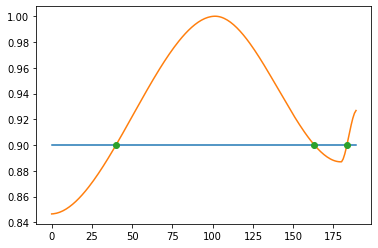

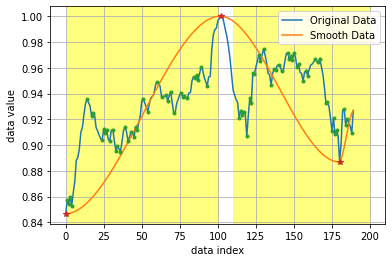

###########Print All Extremas#################
[(36, 0.01514455134977144), (18, 0.01514455134977144), (75, 0.0022111437039965542), (70, 0.0022111437039965542), (151, 7.652712768746461e-05), (150, 7.652712768746461e-05), (154, 0.00014440690848993576), (153, 0.00014440690848993576), (148, 0.0009669398761952275), (155, 0.0009669398761952275), (142, 2.894075619752634e-05), (143, 2.894075619752634e-05), (123, 0.02213237034997384), (141, 0.02213237034997384), (188, 0.06001089608142518), (96, 0.06001089608142518), (0, inf)]
###########Print Filtered Extremas#################
[0]
###########Print Sorted Extremas#################
[(0, inf), (18, 0.01514455134977144), (36, 0.01514455134977144), (70, 0.0022111437039965542), (75, 0.0022111437039965542), (96, 0.06001089608142518), (123, 0.02213237034997384), (141, 0.02213237034997384), (142, 2.894075619752634e-05), (143, 2.894075619752634e-05), (148, 0.0009669398761952275), (150, 7.652712768746461e-05), (151, 7.652712768746461e-05), (153, 0.0001444

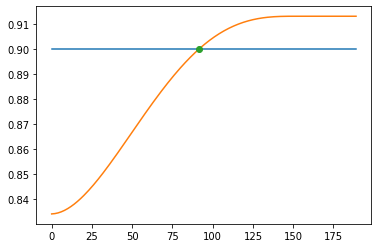

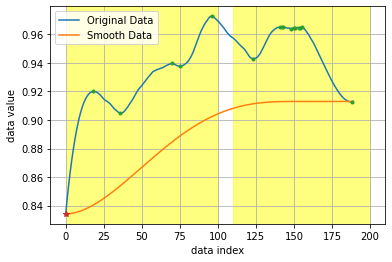

BGS show


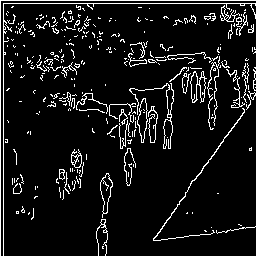

Test case loaded
Test007 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(66, 0.006480222051184814), (68, 0.006480222051184814), (144, 0.0025086832461348463), (145, 0.0025086832461348463), (101, 0.0015194037747245925), (100, 0.0015194037747245925), (99, 0.004638310966797898), (98, 0.004638310966797898), (80, 0.010873148682272071), (78, 0.010873148682272071), (106, 0.0031661863744799623), (105, 0.0031661863744799623), (84, 0.0024012258851936474), (85, 0.0024012258851936474), (12, 0.005144647884182008), (14, 0.005144647884182008), (71, 0.05113757665188523), (83, 0.05113757665188523), (8, 0.00023580010550960928), (9, 0.00023580010550960928), (22, 0.0032958467539596636), (21, 0.0032958467539596636), (1, 0.02873545462147664), (6, 0.02873545462147664), (41, 0.006749670695615939), (42, 0.006749670695615939), (122, 0.0004963095923660177), (121, 0.0004963095923660177), (47, 0.012311691372497768), (45, 0.012311691372497768), (37, 

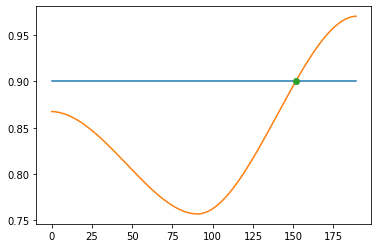

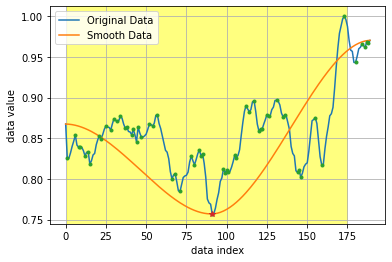

###########Print All Extremas#################
[(9, 0.03471981901443277), (41, 0.03471981901443277), (149, 0.05847242984678447), (124, 0.05847242984678447), (189, 0.03152891750031983), (181, 0.03152891750031983), (87, inf)]
###########Print Filtered Extremas#################
[87]
###########Print Sorted Extremas#################
[(9, 0.03471981901443277), (41, 0.03471981901443277), (87, inf), (124, 0.05847242984678447), (149, 0.05847242984678447), (181, 0.03152891750031983), (189, 0.03152891750031983)]
###########Print Minimas#################
[(9, 0.03471981901443277), (87, inf), (149, 0.05847242984678447), (189, 0.03152891750031983)]
###########Print Maximas#################
[(41, 0.03471981901443277), (124, 0.05847242984678447), (181, 0.03152891750031983)]


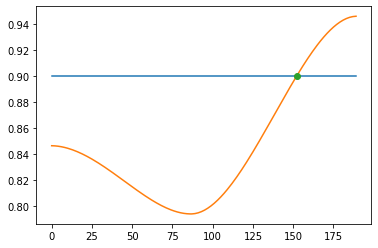

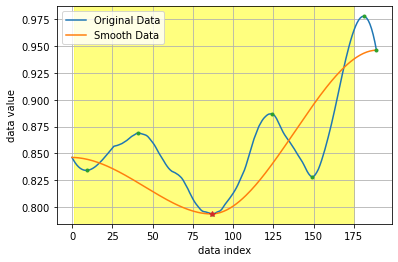

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(95, 0.0006132592246470558), (94, 0.0006132592246470558), (89, 0.0017344527717677583), (90, 0.0017344527717677583), (99, 0.0014146669817993729), (98, 0.0014146669817993729), (102, 0.000449230119939914), (103, 0.000449230119939914), (106, 0.00866580321426691), (105, 0.00866580321426691), (104, 0.010667597017814279), (101, 0.010667597017814279), (74, 0.004470848288499418), (73, 0.004470848288499418), (7, 0.007411177567317129), (6, 0.007411177567317129), (108, 0.0064403475382806), (107, 0.0064403475382806), (10, 0.00041455708446014317), (9, 0.00041455708446014317), (79, 0.0008577103508304873), (78, 0.0008577103508304873), (150, 0.0005843416992391548), (148, 0.0005843416992391548), (70, 0.029963551776246544), (84, 0.029963551776246544), (15, 0.00785159889398257), (13, 0.00785159889398257), (140, 0.00010777887136348419), (141, 0.00010777887136348419), (22, 0.011190970689700763), (20, 0.01119

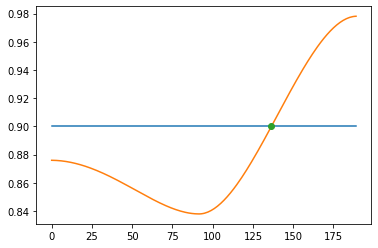

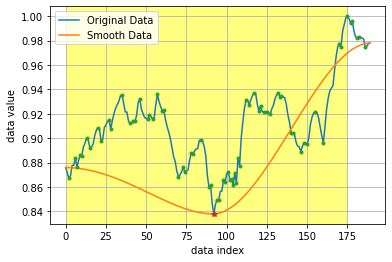

###########Print All Extremas#################
[(0, 0.05689485344501144), (46, 0.05689485344501144), (149, 0.028655642859370167), (126, 0.028655642859370167), (189, 0.025389800044983035), (180, 0.025389800044983035), (90, inf)]
###########Print Filtered Extremas#################
[90]
###########Print Sorted Extremas#################
[(0, 0.05689485344501144), (46, 0.05689485344501144), (90, inf), (126, 0.028655642859370167), (149, 0.028655642859370167), (180, 0.025389800044983035), (189, 0.025389800044983035)]
###########Print Minimas#################
[(0, 0.05689485344501144), (90, inf), (149, 0.028655642859370167), (189, 0.025389800044983035)]
###########Print Maximas#################
[(46, 0.05689485344501144), (126, 0.028655642859370167), (180, 0.025389800044983035)]


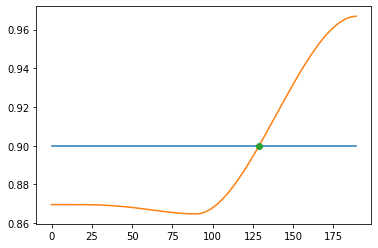

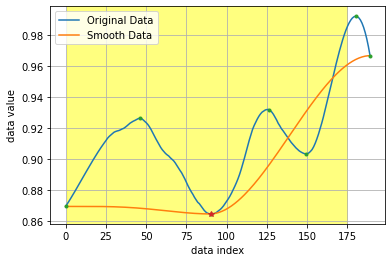

BGS show


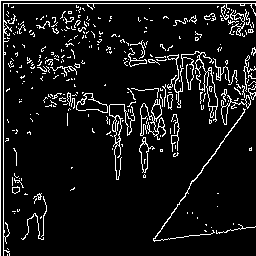

Test case loaded
Test008 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(80, 0.004545110647769857), (79, 0.004545110647769857), (69, 0.009926825085988744), (71, 0.009926825085988744), (43, 0.0016371366670530074), (45, 0.0016371366670530074), (87, 0.0015148619947159547), (85, 0.0015148619947159547), (100, 0.010691679507247365), (102, 0.010691679507247365), (109, 0.003541442871974887), (107, 0.003541442871974887), (56, 0.00772969910762622), (55, 0.00772969910762622), (53, 0.012579685905557692), (49, 0.012579685905557692), (90, 0.0011801316082531432), (89, 0.0011801316082531432), (92, 0.0006820070635176201), (91, 0.0006820070635176201), (60, 0.00612122625046152), (62, 0.00612122625046152), (46, 0.021852741366499395), (58, 0.021852741366499395), (105, 0.04493220072964277), (95, 0.04493220072964277), (3, 0.0027920369575871185), (4, 0.0027920369575871185), (30, 5.3165159540013995e-05), (31, 5.3165159540013995e-05), (34, 0.029

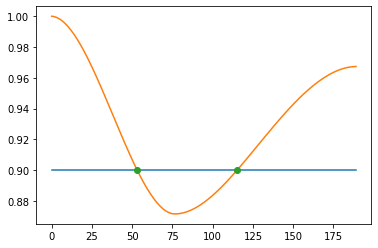

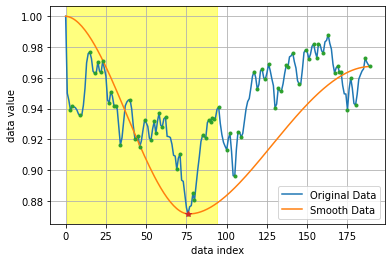

###########Print All Extremas#################
[(48, 0.0012284478444132274), (51, 0.0012284478444132274), (25, 0.0005362910762747308), (26, 0.0005362910762747308), (0, 0.01323256739395573), (14, 0.01323256739395573), (136, 8.586643317776144e-05), (135, 8.586643317776144e-05), (179, 0.021793034370929498), (155, 0.021793034370929498), (73, inf)]
###########Print Filtered Extremas#################
[73]
###########Print Sorted Extremas#################
[(0, 0.01323256739395573), (14, 0.01323256739395573), (25, 0.0005362910762747308), (26, 0.0005362910762747308), (48, 0.0012284478444132274), (51, 0.0012284478444132274), (73, inf), (135, 8.586643317776144e-05), (136, 8.586643317776144e-05), (155, 0.021793034370929498), (179, 0.021793034370929498)]
###########Print Minimas#################
[(0, 0.01323256739395573), (25, 0.0005362910762747308), (48, 0.0012284478444132274), (73, inf), (136, 8.586643317776144e-05), (179, 0.021793034370929498)]
###########Print Maximas#################
[(14, 0.0

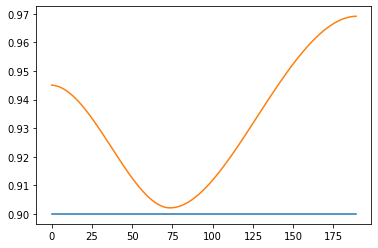

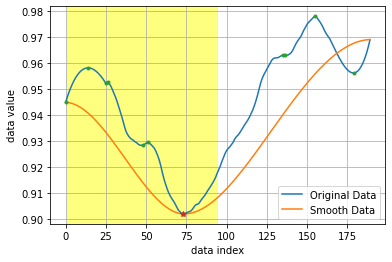

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(80, 0.0013080139502730237), (79, 0.0013080139502730237), (70, 0.0026545418364957163), (71, 0.0026545418364957163), (63, 0.004099180456563101), (65, 0.004099180456563101), (54, 0.0013150946043630762), (55, 0.0013150946043630762), (56, 0.010276746973534423), (60, 0.010276746973534423), (43, 0.00279486862776801), (44, 0.00279486862776801), (86, 0.00034319970664264954), (85, 0.00034319970664264954), (30, 0.004664037110706065), (32, 0.004664037110706065), (50, 0.0013266341059247067), (51, 0.0013266341059247067), (26, 0.0007300643788847871), (27, 0.0007300643788847871), (46, 0.015655718308148825), (49, 0.015655718308148825), (90, 0.0020123054712237742), (88, 0.0020123054712237742), (92, 1.972565933316961e-05), (91, 1.972565933316961e-05), (39, 0.0023465229942045696), (40, 0.0023465229942045696), (34, 0.027250711176840525), (38, 0.027250711176840525), (21, 0.0033387767895383114), (20, 0.00333

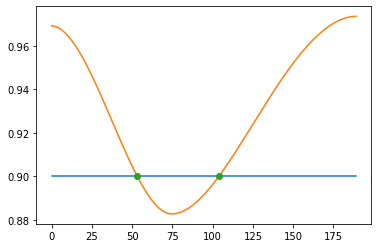

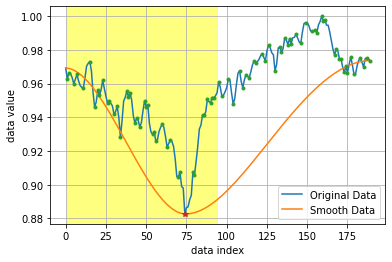

###########Print All Extremas#################
[(48, 0.00010373887156611694), (49, 0.00010373887156611694), (0, 0.00037502345883888566), (3, 0.00037502345883888566), (181, 0.02329233523798302), (154, 0.02329233523798302), (72, inf)]
###########Print Filtered Extremas#################
[72]
###########Print Sorted Extremas#################
[(0, 0.00037502345883888566), (3, 0.00037502345883888566), (48, 0.00010373887156611694), (49, 0.00010373887156611694), (72, inf), (154, 0.02329233523798302), (181, 0.02329233523798302)]
###########Print Minimas#################
[(0, 0.00037502345883888566), (48, 0.00010373887156611694), (72, inf), (181, 0.02329233523798302)]
###########Print Maximas#################
[(3, 0.00037502345883888566), (49, 0.00010373887156611694), (154, 0.02329233523798302)]


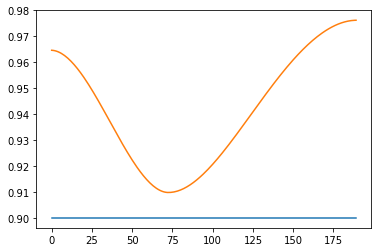

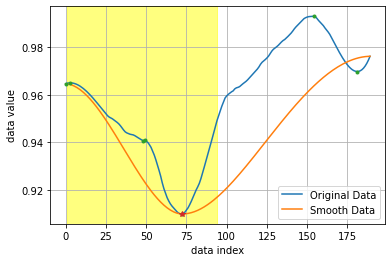

BGS show


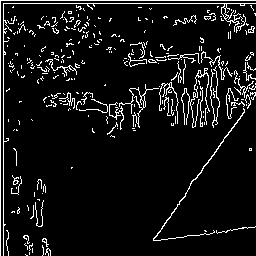

Test case loaded
Test009 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(9, 0.012411501247881485), (10, 0.012411501247881485), (35, 0.0038184725758162452), (33, 0.0038184725758162452), (30, 0.02326235755592554), (28, 0.02326235755592554), (75, 0.0050556897467943784), (74, 0.0050556897467943784), (77, 0.0002886139248587938), (76, 0.0002886139248587938), (79, 0.010432660582565534), (78, 0.010432660582565534), (1, 0.018324100100272522), (4, 0.018324100100272522), (184, 0.0017406283833971692), (185, 0.0017406283833971692), (82, 0.004508543308062385), (81, 0.004508543308062385), (181, 0.0016908113844790185), (182, 0.0016908113844790185), (64, 0.003943197694273093), (66, 0.003943197694273093), (178, 0.001643532212830534), (179, 0.001643532212830534), (59, 0.0019512529499435827), (60, 0.0019512529499435827), (147, 0.00030321220498019663), (148, 0.00030321220498019663), (56, 0.029815412430573063), (58, 0.029815412430573063), (1

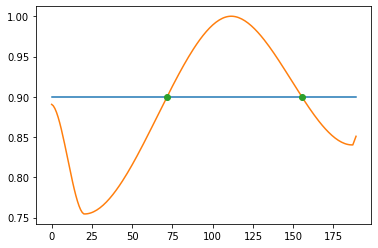

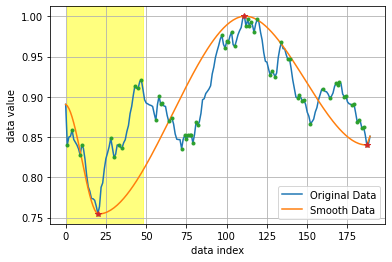

###########Print All Extremas#################
[(53, 8.043024431747536e-05), (54, 8.043024431747536e-05), (71, 0.04028480776621468), (50, 0.04028480776621468), (158, 0.010883618062426659), (171, 0.010883618062426659), (189, 0.16190402640105284), (107, 0.16190402640105284), (17, inf)]
###########Print Filtered Extremas#################
[17, 107, 189]
###########Print Sorted Extremas#################
[(17, inf), (50, 0.04028480776621468), (53, 8.043024431747536e-05), (54, 8.043024431747536e-05), (71, 0.04028480776621468), (107, 0.16190402640105284), (158, 0.010883618062426659), (171, 0.010883618062426659), (189, 0.16190402640105284)]
###########Print Minimas#################
[(17, inf), (53, 8.043024431747536e-05), (71, 0.04028480776621468), (158, 0.010883618062426659), (189, 0.16190402640105284)]
###########Print Maximas#################
[(50, 0.04028480776621468), (54, 8.043024431747536e-05), (107, 0.16190402640105284), (171, 0.010883618062426659)]


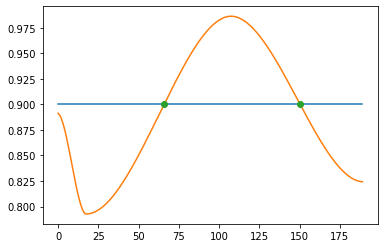

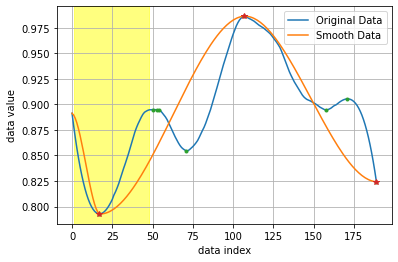

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(20, 0.014000225935774324), (18, 0.014000225935774324), (23, 0.0040059058464152475), (22, 0.0040059058464152475), (9, 0.007332847197622838), (10, 0.007332847197622838), (1, 0.01702253369256146), (4, 0.01702253369256146), (36, 0.002429527713839863), (35, 0.002429527713839863), (39, 0.007664024538638237), (38, 0.007664024538638237), (69, 0.003771405357741897), (71, 0.003771405357741897), (79, 0.005042699210197066), (78, 0.005042699210197066), (189, 0.0003388732990093901), (188, 0.0003388732990093901), (72, 0.010826045087061864), (74, 0.010826045087061864), (184, 0.00037897390560592825), (185, 0.00037897390560592825), (45, 0.001826876964107882), (44, 0.001826876964107882), (65, 0.0010462118813225896), (66, 0.0010462118813225896), (51, 0.0004188128470343777), (50, 0.0004188128470343777), (61, 0.001772154342656318), (62, 0.001772154342656318), (179, 0.0031769716679262983), (180, 0.0031769716

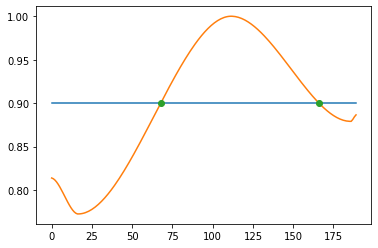

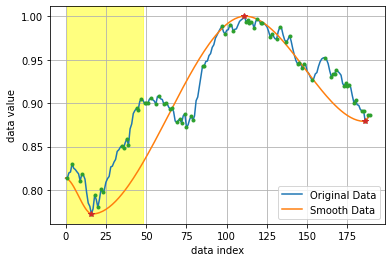

###########Print All Extremas#################
[(69, 0.014706399419848748), (55, 0.014706399419848748), (109, 0.000378570996198202), (112, 0.000378570996198202), (189, 0.12486171616305453), (107, 0.12486171616305453), (15, inf)]
###########Print Filtered Extremas#################
[15, 107, 189]
###########Print Sorted Extremas#################
[(15, inf), (55, 0.014706399419848748), (69, 0.014706399419848748), (107, 0.12486171616305453), (109, 0.000378570996198202), (112, 0.000378570996198202), (189, 0.12486171616305453)]
###########Print Minimas#################
[(15, inf), (69, 0.014706399419848748), (109, 0.000378570996198202), (189, 0.12486171616305453)]
###########Print Maximas#################
[(55, 0.014706399419848748), (107, 0.12486171616305453), (112, 0.000378570996198202)]


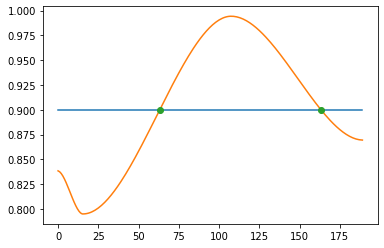

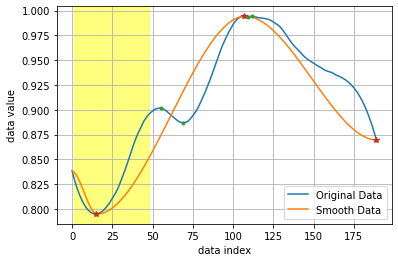

BGS show


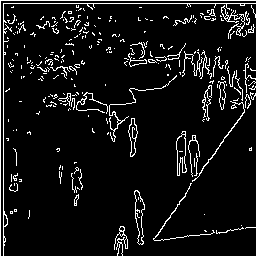

Test case loaded
Test010 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(4, 0.0009103415582223384), (3, 0.0009103415582223384), (39, 0.0014064364263020046), (38, 0.0014064364263020046), (7, 0.010110797896697332), (6, 0.010110797896697332), (91, 0.0025158362856724237), (90, 0.0025158362856724237), (70, 0.016512853754756862), (67, 0.016512853754756862), (13, 0.007987572821236077), (11, 0.007987572821236077), (25, 0.012751690436909602), (23, 0.012751690436909602), (27, 0.009365834420484997), (26, 0.009365834420484997), (55, 0.004238961249063089), (57, 0.004238961249063089), (21, 0.0443248051031907), (31, 0.0443248051031907), (37, 0.07265988584255978), (17, 0.07265988584255978), (77, 0.00020086034745681047), (76, 0.00020086034745681047), (63, 0.06901962064432743), (78, 0.06901962064432743), (51, 0.006423967924158336), (50, 0.006423967924158336), (87, 0.12580186777450775), (54, 0.12580186777450775), (121, 0.02873737830208678

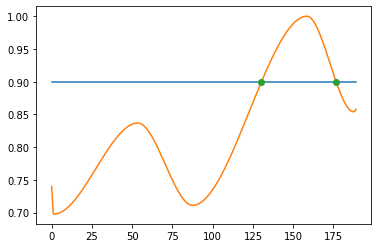

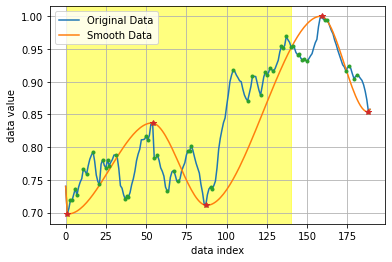

###########Print All Extremas#################
[(25, 0.0004366601743467369), (26, 0.0004366601743467369), (29, 0.011209409862410702), (17, 0.011209409862410702), (53, 0.0030105878813719844), (45, 0.0030105878813719844), (78, 0.038856785481847456), (62, 0.038856785481847456), (162, 0.00035525923999313314), (163, 0.00035525923999313314), (189, 0.11407021939796635), (154, 0.11407021939796635), (0, inf)]
###########Print Filtered Extremas#################
[0, 154, 189]
###########Print Sorted Extremas#################
[(0, inf), (17, 0.011209409862410702), (25, 0.0004366601743467369), (26, 0.0004366601743467369), (29, 0.011209409862410702), (45, 0.0030105878813719844), (53, 0.0030105878813719844), (62, 0.038856785481847456), (78, 0.038856785481847456), (154, 0.11407021939796635), (162, 0.00035525923999313314), (163, 0.00035525923999313314), (189, 0.11407021939796635)]
###########Print Minimas#################
[(0, inf), (25, 0.0004366601743467369), (29, 0.011209409862410702), (53, 0.003010

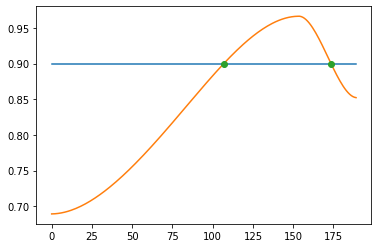

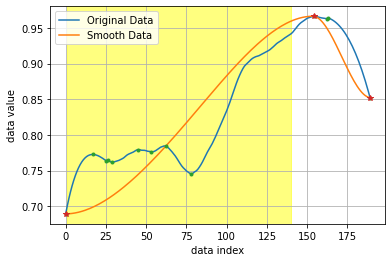

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(3, 0.0007872116717055899), (2, 0.0007872116717055899), (5, 0.0023953945792064557), (4, 0.0023953945792064557), (12, 0.0036165614944811963), (11, 0.0036165614944811963), (21, 0.020315780111819226), (16, 0.020315780111819226), (24, 0.004624416114279661), (23, 0.004624416114279661), (34, 0.0018342079016617774), (35, 0.0018342079016617774), (39, 0.02654928687924374), (30, 0.02654928687924374), (56, 0.002367534264101856), (57, 0.002367534264101856), (71, 0.01091196325396837), (67, 0.01091196325396837), (51, 0.00131589897177109), (50, 0.00131589897177109), (81, 0.00018856406040324014), (82, 0.00018856406040324014), (78, 0.0002874076002855608), (79, 0.0002874076002855608), (86, 0.031201508076250217), (76, 0.031201508076250217), (64, 0.10273994278552556), (54, 0.10273994278552556), (91, 0.004370433395384232), (90, 0.004370433395384232), (117, 0.003931428594029729), (118, 0.003931428594029729),

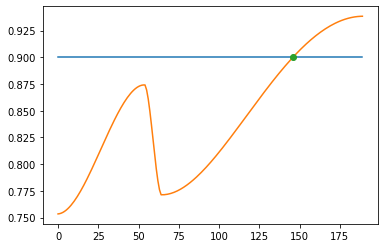

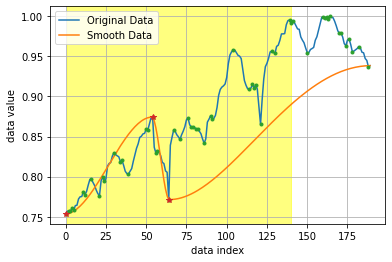

###########Print All Extremas#################
[(51, 0.0012159865680370086), (46, 0.0012159865680370086), (71, 0.0026015418976699234), (62, 0.0026015418976699234), (113, 0.0006602833004464292), (111, 0.0006602833004464292), (162, 0.0008770153848756124), (167, 0.0008770153848756124), (148, 0.0006836238665390848), (146, 0.0006836238665390848), (189, 0.056477917591650106), (154, 0.056477917591650106), (0, inf)]
###########Print Filtered Extremas#################
[0]
###########Print Sorted Extremas#################
[(0, inf), (46, 0.0012159865680370086), (51, 0.0012159865680370086), (62, 0.0026015418976699234), (71, 0.0026015418976699234), (111, 0.0006602833004464292), (113, 0.0006602833004464292), (146, 0.0006836238665390848), (148, 0.0006836238665390848), (154, 0.056477917591650106), (162, 0.0008770153848756124), (167, 0.0008770153848756124), (189, 0.056477917591650106)]
###########Print Minimas#################
[(0, inf), (51, 0.0012159865680370086), (71, 0.0026015418976699234), (113, 

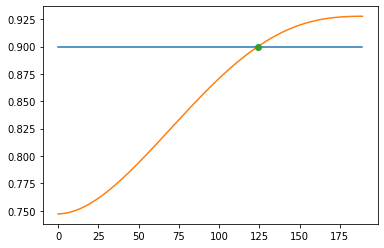

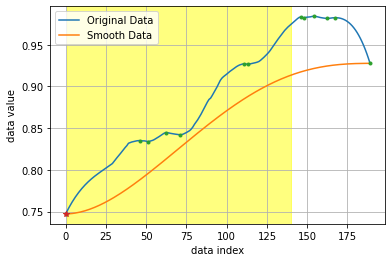

BGS show


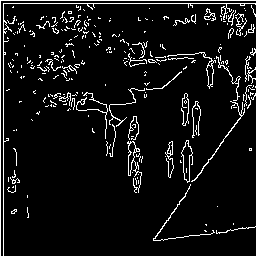

Test case loaded
Test011 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(186, 0.002266145181820889), (187, 0.002266145181820889), (178, 0.009650338282965132), (179, 0.009650338282965132), (172, 0.0061703630094330775), (174, 0.0061703630094330775), (5, 0.005351752176216418), (4, 0.005351752176216418), (11, 0.0017586999979801732), (10, 0.0017586999979801732), (151, 0.0034577692858664966), (153, 0.0034577692858664966), (156, 0.008803887860017179), (159, 0.008803887860017179), (149, 0.005499362062887592), (150, 0.005499362062887592), (143, 0.010564190256080908), (146, 0.010564190256080908), (23, 0.001303284967123175), (24, 0.001303284967123175), (25, 0.03747451111055866), (18, 0.03747451111055866), (103, 0.01031464404815674), (105, 0.01031464404815674), (129, 0.002265709060619958), (130, 0.002265709060619958), (43, 0.03636476951774659), (36, 0.03636476951774659), (55, 0.008118286693194587), (57, 0.008118286693194587), (59, 

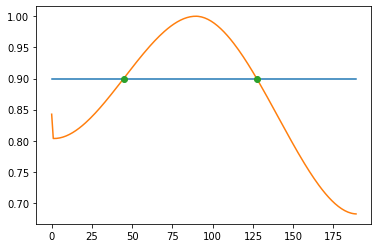

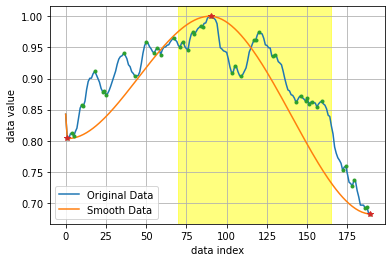

###########Print All Extremas#################
[(110, 0.009511258400901723), (121, 0.009511258400901723), (0, 0.1844055960697525), (84, 0.1844055960697525), (189, inf)]
###########Print Filtered Extremas#################
[0, 84, 189]
###########Print Sorted Extremas#################
[(0, 0.1844055960697525), (84, 0.1844055960697525), (110, 0.009511258400901723), (121, 0.009511258400901723), (189, inf)]
###########Print Minimas#################
[(0, 0.1844055960697525), (110, 0.009511258400901723), (189, inf)]
###########Print Maximas#################
[(84, 0.1844055960697525), (121, 0.009511258400901723)]


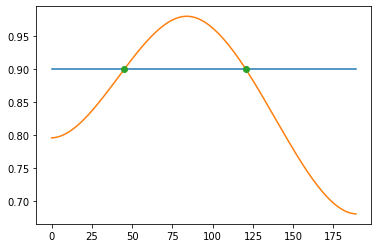

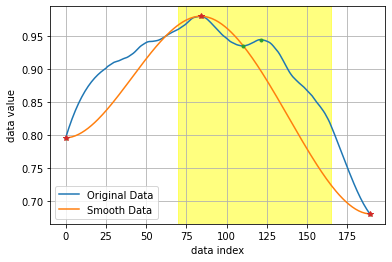

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(186, 0.0013772757393402113), (187, 0.0013772757393402113), (183, 0.0029168848054790253), (185, 0.0029168848054790253), (178, 0.0005125007474059418), (180, 0.0005125007474059418), (172, 0.0008945667614661534), (173, 0.0008945667614661534), (160, 0.004640624829598594), (162, 0.004640624829598594), (149, 0.000692700150572878), (148, 0.000692700150572878), (147, 0.003135716133111699), (146, 0.003135716133111699), (2, 0.00016490153122983298), (1, 0.00016490153122983298), (144, 0.01354542751002219), (150, 0.01354542751002219), (140, 0.0027307052516880592), (142, 0.0027307052516880592), (133, 0.0023532148135392283), (134, 0.0023532148135392283), (11, 0.0024866535749954455), (10, 0.0024866535749954455), (15, 0.0014601400728204705), (14, 0.0014601400728204705), (21, 0.0004504278145747165), (22, 0.0004504278145747165), (45, 6.480748398063341e-05), (44, 6.480748398063341e-05), (23, 0.007252111464

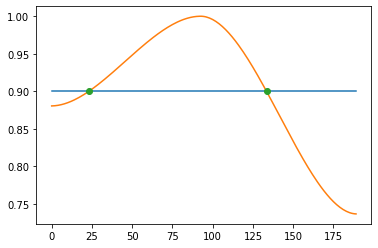

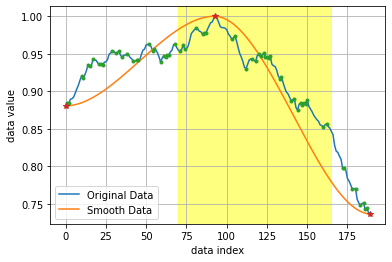

###########Print All Extremas#################
[(42, 0.00019390777748251598), (41, 0.00019390777748251598), (54, 0.0009782520273105), (47, 0.0009782520273105), (0, 0.1136732869189424), (89, 0.1136732869189424), (189, inf)]
###########Print Filtered Extremas#################
[0, 89, 189]
###########Print Sorted Extremas#################
[(0, 0.1136732869189424), (41, 0.00019390777748251598), (42, 0.00019390777748251598), (47, 0.0009782520273105), (54, 0.0009782520273105), (89, 0.1136732869189424), (189, inf)]
###########Print Minimas#################
[(0, 0.1136732869189424), (42, 0.00019390777748251598), (54, 0.0009782520273105), (189, inf)]
###########Print Maximas#################
[(41, 0.00019390777748251598), (47, 0.0009782520273105), (89, 0.1136732869189424)]


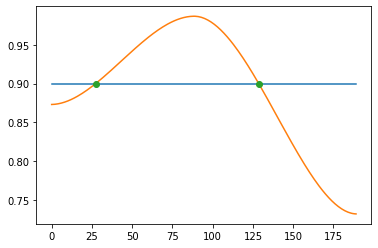

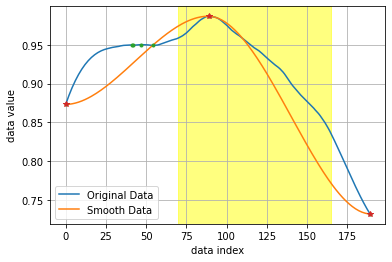

BGS show


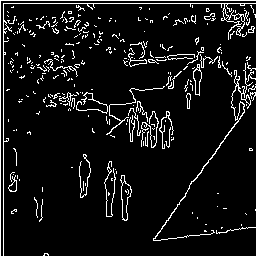

Test case loaded
Test012 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(103, 0.003069648611015219), (105, 0.003069648611015219), (155, 0.013907554018188995), (156, 0.013907554018188995), (161, 0.0027818362485727555), (160, 0.0027818362485727555), (152, 0.01262851458738068), (153, 0.01262851458738068), (97, 0.0004385059476224029), (98, 0.0004385059476224029), (150, 0.004234776979475052), (151, 0.004234776979475052), (164, 0.02179135966085144), (162, 0.02179135966085144), (58, 0.006874376840054319), (57, 0.006874376840054319), (141, 0.0020120656317107466), (142, 0.0020120656317107466), (146, 0.007111479713733715), (147, 0.007111479713733715), (128, 0.001987178019141167), (129, 0.001987178019141167), (61, 0.005627652939504402), (60, 0.005627652939504402), (134, 0.0009480744197050139), (133, 0.0009480744197050139), (46, 0.011100713517372074), (43, 0.011100713517372074), (143, 0.01706082694813915), (145, 0.01706082694813915

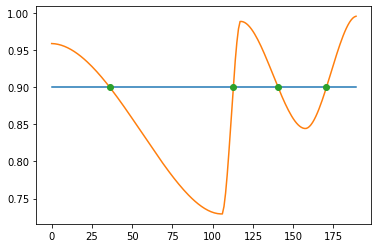

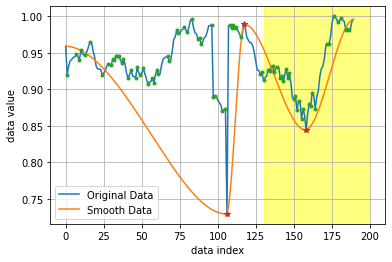

###########Print All Extremas#################
[(42, 0.00012477002815525218), (43, 0.00012477002815525218), (0, 0.00589937630951165), (11, 0.00589937630951165), (100, 0.022785766375564065), (124, 0.022785766375564065), (52, 0.06889350216652779), (81, 0.06889350216652779), (189, 0.005848621839668389), (185, 0.005848621839668389), (154, inf)]
###########Print Filtered Extremas#################
[154]
###########Print Sorted Extremas#################
[(0, 0.00589937630951165), (11, 0.00589937630951165), (42, 0.00012477002815525218), (43, 0.00012477002815525218), (52, 0.06889350216652779), (81, 0.06889350216652779), (100, 0.022785766375564065), (124, 0.022785766375564065), (154, inf), (185, 0.005848621839668389), (189, 0.005848621839668389)]
###########Print Minimas#################
[(0, 0.00589937630951165), (42, 0.00012477002815525218), (52, 0.06889350216652779), (100, 0.022785766375564065), (154, inf), (189, 0.005848621839668389)]
###########Print Maximas#################
[(11, 0.0058993

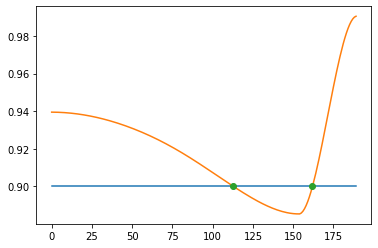

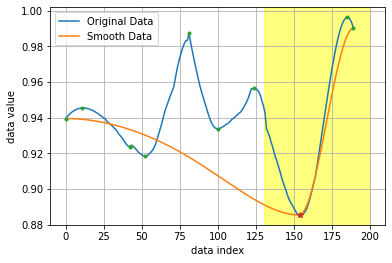

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(103, 0.0013797950735023878), (105, 0.0013797950735023878), (155, 0.0016682898353591602), (156, 0.0016682898353591602), (152, 0.0024332432788700675), (153, 0.0024332432788700675), (164, 0.0014524931228983018), (163, 0.0014524931228983018), (139, 0.0007709702383968953), (138, 0.0007709702383968953), (137, 0.0015887542930830278), (136, 0.0015887542930830278), (134, 0.002784989598694665), (140, 0.002784989598694665), (143, 0.00204559745782551), (142, 0.00204559745782551), (146, 0.0010318896458574311), (147, 0.0010318896458574311), (131, 0.006246855027500664), (132, 0.006246855027500664), (141, 0.011447742469494093), (145, 0.011447742469494093), (126, 0.0017777702642022275), (127, 0.0017777702642022275), (58, 0.0003494345654080355), (57, 0.0003494345654080355), (123, 0.0003315549032715248), (124, 0.0003315549032715248), (61, 0.0028349706763550753), (60, 0.0028349706763550753), (49, 0.001365

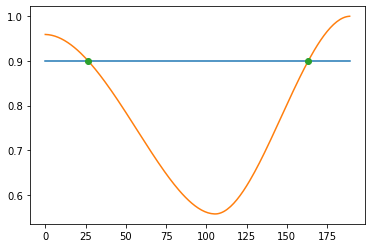

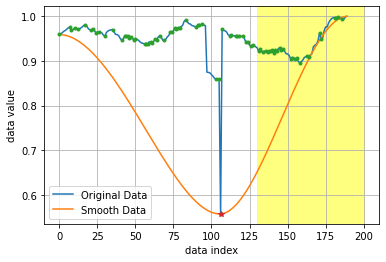

###########Print All Extremas#################
[(107, 0.03584603078711046), (127, 0.03584603078711046), (0, 0.012308236190707644), (14, 0.012308236190707644), (58, 0.04591997150119631), (81, 0.04591997150119631), (153, inf)]
###########Print Filtered Extremas#################
[153]
###########Print Sorted Extremas#################
[(0, 0.012308236190707644), (14, 0.012308236190707644), (58, 0.04591997150119631), (81, 0.04591997150119631), (107, 0.03584603078711046), (127, 0.03584603078711046), (153, inf)]
###########Print Minimas#################
[(0, 0.012308236190707644), (58, 0.04591997150119631), (107, 0.03584603078711046), (153, inf)]
###########Print Maximas#################
[(14, 0.012308236190707644), (81, 0.04591997150119631), (127, 0.03584603078711046)]


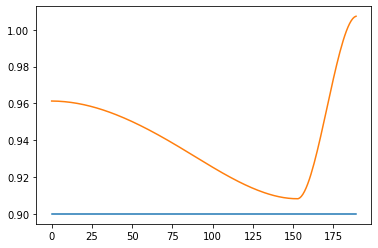

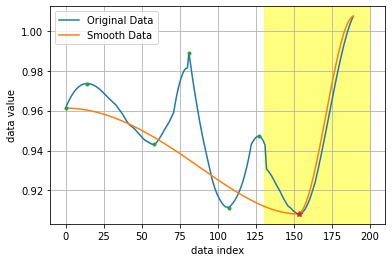

BGS show


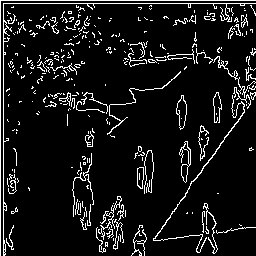

Test case loaded
Test013 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(103, 0.0011289736753451463), (104, 0.0011289736753451463), (108, 0.015040730891853982), (107, 0.015040730891853982), (99, 0.013156702795124486), (102, 0.013156702795124486), (15, 0.017953494943366954), (18, 0.017953494943366954), (126, 0.00555804251307046), (125, 0.00555804251307046), (2, 0.00042781429457194875), (3, 0.00042781429457194875), (6, 0.038365162658623664), (9, 0.038365162658623664), (95, 0.00041025805774896895), (96, 0.00041025805774896895), (132, 0.040622961035295724), (129, 0.040622961035295724), (33, 0.000769372381496547), (32, 0.000769372381496547), (115, 0.0006419257542015222), (114, 0.0006419257542015222), (57, 0.005028405474399644), (56, 0.005028405474399644), (82, 0.0027915130176030534), (81, 0.0027915130176030534), (91, 0.020991045602525293), (94, 0.020991045602525293), (105, 0.10149517369456462), (116, 0.10149517369456462), (8

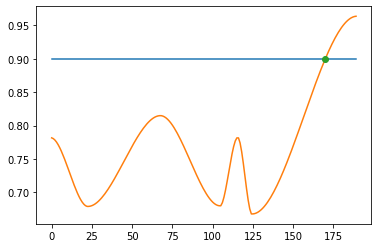

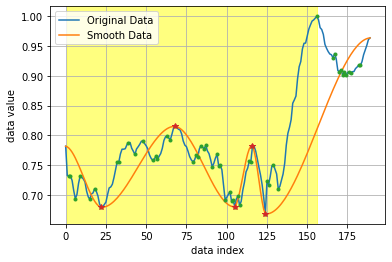

###########Print All Extremas#################
[(97, 0.0010559835341570345), (99, 0.0010559835341570345), (60, 3.3691953725600854e-05), (61, 3.3691953725600854e-05), (56, 6.88000221438223e-06), (57, 6.88000221438223e-06), (62, 0.0012949659358431065), (55, 0.0012949659358431065), (69, 4.3586742124457345e-06), (70, 4.3586742124457345e-06), (71, 0.0009282413665224754), (67, 0.0009282413665224754), (117, 0.07452487631427585), (76, 0.07452487631427585), (178, 0.07026706915818037), (158, 0.07026706915818037), (15, inf)]
###########Print Filtered Extremas#################
[15]
###########Print Sorted Extremas#################
[(15, inf), (55, 0.0012949659358431065), (56, 6.88000221438223e-06), (57, 6.88000221438223e-06), (60, 3.3691953725600854e-05), (61, 3.3691953725600854e-05), (62, 0.0012949659358431065), (67, 0.0009282413665224754), (69, 4.3586742124457345e-06), (70, 4.3586742124457345e-06), (71, 0.0009282413665224754), (76, 0.07452487631427585), (97, 0.0010559835341570345), (99, 0.001055

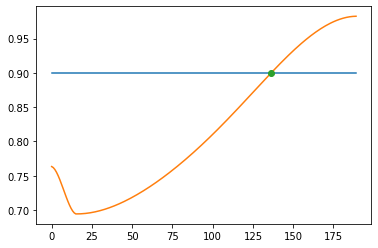

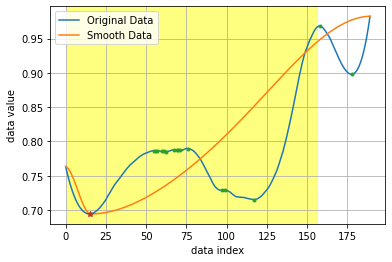

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(120, 0.0031581554711520576), (121, 0.0031581554711520576), (28, 0.002884169104071743), (27, 0.002884169104071743), (126, 0.0110032707986083), (125, 0.0110032707986083), (99, 0.008485766955247165), (102, 0.008485766955247165), (105, 0.018569629781623798), (107, 0.018569629781623798), (135, 0.010641931356131673), (134, 0.010641931356131673), (13, 0.013309024167681205), (18, 0.013309024167681205), (6, 0.020486897864951947), (9, 0.020486897864951947), (113, 0.0006181955633827174), (112, 0.0006181955633827174), (132, 0.02922936181413527), (129, 0.02922936181413527), (115, 0.008703260872333751), (114, 0.008703260872333751), (33, 0.0005684475679291756), (32, 0.0005684475679291756), (1, 0.0018594262300192232), (2, 0.0018594262300192232), (109, 0.042283387736938516), (117, 0.042283387736938516), (95, 0.0003075391894458157), (96, 0.0003075391894458157), (37, 0.0010185789928337519), (35, 0.001018

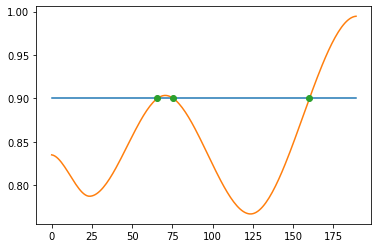

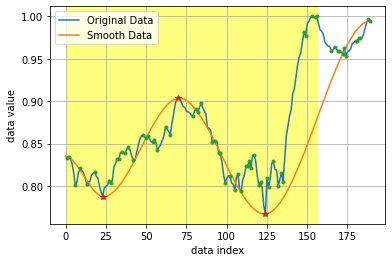

###########Print All Extremas#################
[(17, 0.08741797404358087), (77, 0.08741797404358087), (176, 0.03036187395007428), (158, 0.03036187395007428), (118, inf)]
###########Print Filtered Extremas#################
[118]
###########Print Sorted Extremas#################
[(17, 0.08741797404358087), (77, 0.08741797404358087), (118, inf), (158, 0.03036187395007428), (176, 0.03036187395007428)]
###########Print Minimas#################
[(17, 0.08741797404358087), (118, inf), (176, 0.03036187395007428)]
###########Print Maximas#################
[(77, 0.08741797404358087), (158, 0.03036187395007428)]


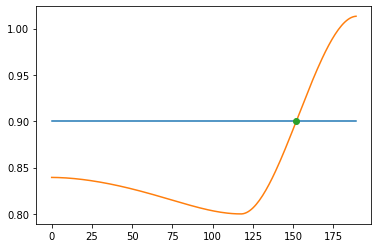

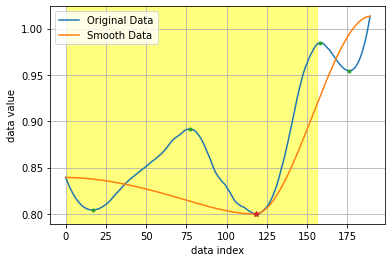

BGS show


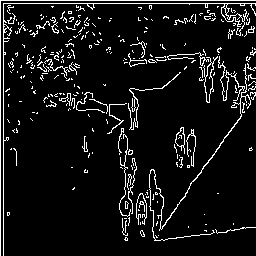

Test case loaded
Test014 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(122, 0.015918461389857974), (121, 0.015918461389857974), (124, 0.0048942677936785195), (123, 0.0048942677936785195), (127, 0.013219068671194711), (125, 0.013219068671194711), (129, 0.01127123685919984), (128, 0.01127123685919984), (132, 0.01544296845010984), (131, 0.01544296845010984), (135, 0.004979871895806065), (134, 0.004979871895806065), (138, 0.011548723619665635), (136, 0.011548723619665635), (143, 0.01200133002539483), (141, 0.01200133002539483), (147, 0.007769718936341263), (145, 0.007769718936341263), (161, 0.0017607778286153897), (160, 0.0017607778286153897), (164, 0.0070375786854807165), (162, 0.0070375786854807165), (150, 0.0023860415263209367), (149, 0.0023860415263209367), (159, 0.015661121060913885), (165, 0.015661121060913885), (152, 0.0020077525946557984), (151, 0.0020077525946557984), (155, 0.013570597145660668), (153, 0.01357059

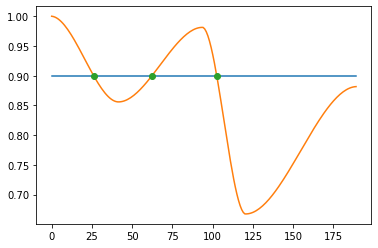

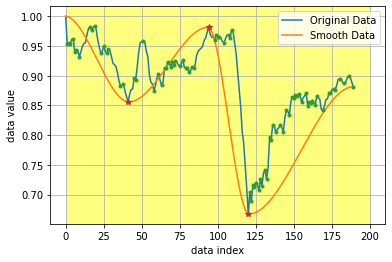

###########Print All Extremas#################
[(159, 0.0004309800439583622), (157, 0.0004309800439583622), (72, 0.007562880083136325), (61, 0.007562880083136325), (0, 0.03836832588596106), (11, 0.03836832588596106), (45, 0.07730290331770795), (97, 0.07730290331770795), (130, inf)]
###########Print Filtered Extremas#################
[130]
###########Print Sorted Extremas#################
[(0, 0.03836832588596106), (11, 0.03836832588596106), (45, 0.07730290331770795), (61, 0.007562880083136325), (72, 0.007562880083136325), (97, 0.07730290331770795), (130, inf), (157, 0.0004309800439583622), (159, 0.0004309800439583622)]
###########Print Minimas#################
[(0, 0.03836832588596106), (45, 0.07730290331770795), (72, 0.007562880083136325), (130, inf), (159, 0.0004309800439583622)]
###########Print Maximas#################
[(11, 0.03836832588596106), (61, 0.007562880083136325), (97, 0.07730290331770795), (157, 0.0004309800439583622)]


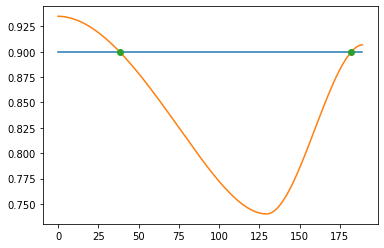

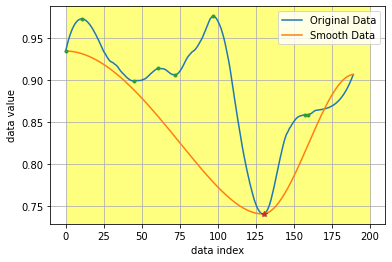

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(122, 0.0311517164533045), (121, 0.0311517164533045), (129, 0.008054395477206211), (128, 0.008054395477206211), (124, 0.01581629982702981), (123, 0.01581629982702981), (127, 0.015072217609420235), (125, 0.015072217609420235), (132, 0.011572519038966278), (131, 0.011572519038966278), (138, 0.028876444510718136), (135, 0.028876444510718136), (147, 0.006424001506975641), (146, 0.006424001506975641), (170, 0.00039288015658378583), (169, 0.00039288015658378583), (172, 0.00022878287894234628), (171, 0.00022878287894234628), (164, 0.005963156507463929), (162, 0.005963156507463929), (168, 0.009467809957135476), (165, 0.009467809957135476), (155, 0.007189249504115702), (157, 0.007189249504115702), (159, 0.015076013456327364), (154, 0.015076013456327364), (37, 0.00665373736313335), (38, 0.00665373736313335), (177, 0.0009891328078412975), (176, 0.0009891328078412975), (46, 0.009782994113444188), (

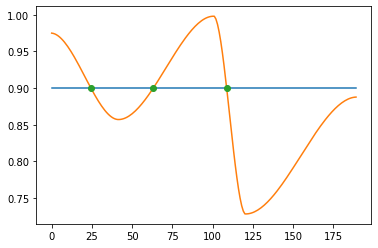

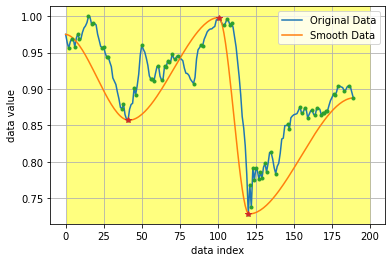

###########Print All Extremas#################
[(63, 1.2007556184912005e-06), (62, 1.2007556184912005e-06), (74, 0.007975839391738404), (64, 0.007975839391738404), (43, 0.09309510224920381), (97, 0.09309510224920381), (0, 0.06486013492202491), (11, 0.06486013492202491), (131, inf)]
###########Print Filtered Extremas#################
[131]
###########Print Sorted Extremas#################
[(0, 0.06486013492202491), (11, 0.06486013492202491), (43, 0.09309510224920381), (62, 1.2007556184912005e-06), (63, 1.2007556184912005e-06), (64, 0.007975839391738404), (74, 0.007975839391738404), (97, 0.09309510224920381), (131, inf)]
###########Print Minimas#################
[(0, 0.06486013492202491), (43, 0.09309510224920381), (63, 1.2007556184912005e-06), (74, 0.007975839391738404), (131, inf)]
###########Print Maximas#################
[(11, 0.06486013492202491), (62, 1.2007556184912005e-06), (64, 0.007975839391738404), (97, 0.09309510224920381)]


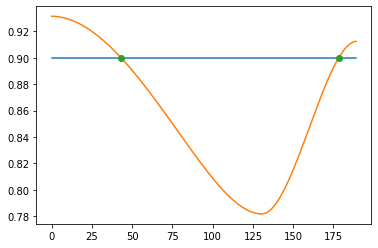

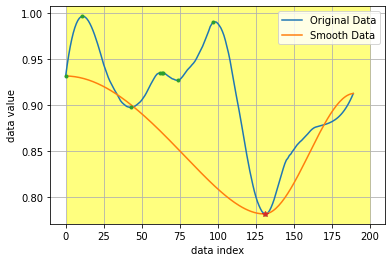

BGS show


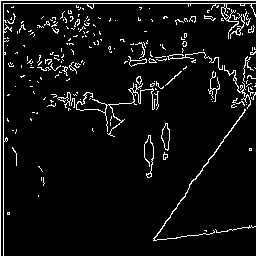

Test case loaded
Test015 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(14, 0.0008539853916991191), (13, 0.0008539853916991191), (12, 0.006611252964440317), (16, 0.006611252964440317), (33, 0.0028892271057906482), (34, 0.0028892271057906482), (38, 0.020083106156183583), (28, 0.020083106156183583), (163, 0.00796281669991683), (162, 0.00796281669991683), (166, 0.0019112155063245595), (165, 0.0019112155063245595), (175, 0.006583636736509191), (176, 0.006583636736509191), (161, 0.05022097425336025), (170, 0.05022097425336025), (149, 0.002960205362390722), (150, 0.002960205362390722), (155, 0.0008981677064576754), (156, 0.0008981677064576754), (151, 0.010523215555330756), (154, 0.010523215555330756), (134, 0.005499733527939199), (133, 0.005499733527939199), (73, 0.0015332496962885411), (72, 0.0015332496962885411), (76, 0.0013557084335070746), (75, 0.0013557084335070746), (66, 0.005423959915870857), (68, 0.005423959915870857

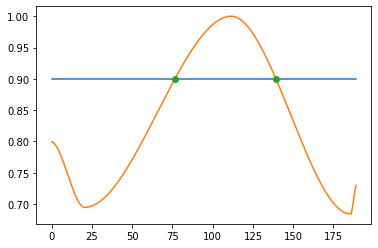

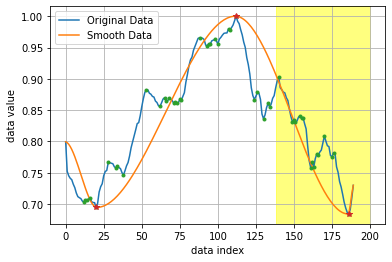

###########Print All Extremas#################
[(16, 0.2725924489652628), (101, 0.2725924489652628), (189, inf)]
###########Print Filtered Extremas#################
[16, 101, 189]
###########Print Sorted Extremas#################
[(16, 0.2725924489652628), (101, 0.2725924489652628), (189, inf)]
###########Print Minimas#################
[(16, 0.2725924489652628), (189, inf)]
###########Print Maximas#################
[(101, 0.2725924489652628)]


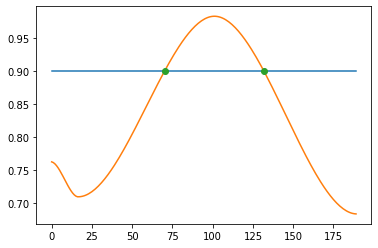

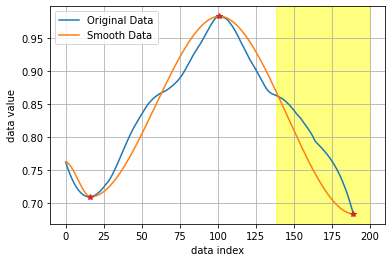

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(176, 0.00028744131593982924), (177, 0.00028744131593982924), (24, 0.002624377464421457), (22, 0.002624377464421457), (9, 5.8569763365379224e-05), (10, 5.8569763365379224e-05), (20, 0.011199053314463914), (17, 0.011199053314463914), (166, 0.0011208817432162288), (167, 0.0011208817432162288), (37, 0.0034412510210304337), (35, 0.0034412510210304337), (168, 0.006244836775404883), (164, 0.006244836775404883), (32, 0.011607420747552943), (28, 0.011607420747552943), (4, 0.0083060821480192), (6, 0.0083060821480192), (163, 0.010839620496182256), (170, 0.010839620496182256), (161, 0.006584826966557267), (162, 0.006584826966557267), (41, 0.004012057892804455), (40, 0.004012057892804455), (155, 0.004681982508409233), (156, 0.004681982508409233), (48, 0.006808944127452254), (47, 0.006808944127452254), (150, 0.005717917231751302), (153, 0.005717917231751302), (148, 0.0024508410526350444), (149, 0.00

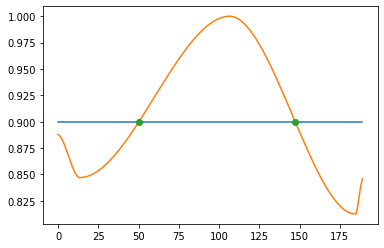

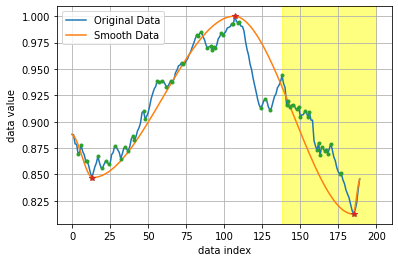

###########Print All Extremas#################
[(135, 3.716428356836943e-05), (136, 3.716428356836943e-05), (137, 0.00034451991030060025), (139, 0.00034451991030060025), (18, 0.1308495079516111), (99, 0.1308495079516111), (189, inf)]
###########Print Filtered Extremas#################
[18, 99, 189]
###########Print Sorted Extremas#################
[(18, 0.1308495079516111), (99, 0.1308495079516111), (135, 3.716428356836943e-05), (136, 3.716428356836943e-05), (137, 0.00034451991030060025), (139, 0.00034451991030060025), (189, inf)]
###########Print Minimas#################
[(18, 0.1308495079516111), (135, 3.716428356836943e-05), (137, 0.00034451991030060025), (189, inf)]
###########Print Maximas#################
[(99, 0.1308495079516111), (136, 3.716428356836943e-05), (139, 0.00034451991030060025)]


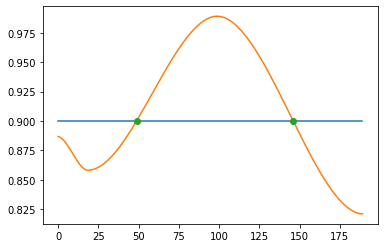

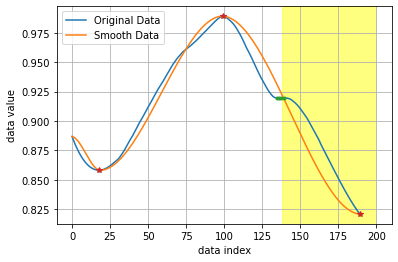

BGS show


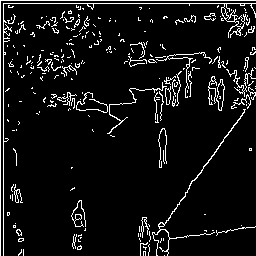

Test case loaded
Test016 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(138, 0.006439706341359708), (137, 0.006439706341359708), (176, 0.0008809515636043486), (177, 0.0008809515636043486), (182, 0.005088762430073612), (180, 0.005088762430073612), (174, 0.00184663344144953), (175, 0.00184663344144953), (114, 0.00453297041201961), (115, 0.00453297041201961), (127, 0.002834753399540757), (128, 0.002834753399540757), (172, 0.0022046026228953464), (173, 0.0022046026228953464), (121, 0.0008461347570400957), (120, 0.0008461347570400957), (110, 0.005580731650744131), (111, 0.005580731650744131), (92, 0.0013148095001568327), (93, 0.0013148095001568327), (98, 0.0017957185820486332), (97, 0.0017957185820486332), (169, 0.0030100819210198138), (170, 0.0030100819210198138), (124, 0.003463497633386381), (125, 0.003463497633386381), (187, 0.004384752541268799), (186, 0.004384752541268799), (116, 0.030749272325747756), (122, 0.03074927

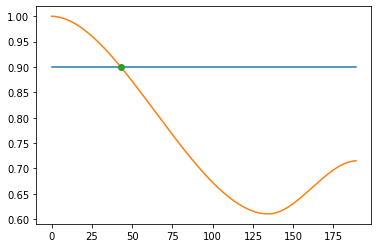

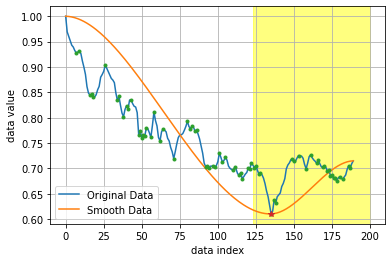

###########Print All Extremas#################
[(107, 0.0024915126275891764), (113, 0.0024915126275891764), (179, 0.03498775018564282), (159, 0.03498775018564282), (65, 0.005970598969999741), (73, 0.005970598969999741), (131, inf)]
###########Print Filtered Extremas#################
[131]
###########Print Sorted Extremas#################
[(65, 0.005970598969999741), (73, 0.005970598969999741), (107, 0.0024915126275891764), (113, 0.0024915126275891764), (131, inf), (159, 0.03498775018564282), (179, 0.03498775018564282)]
###########Print Minimas#################
[(65, 0.005970598969999741), (107, 0.0024915126275891764), (131, inf), (179, 0.03498775018564282)]
###########Print Maximas#################
[(73, 0.005970598969999741), (113, 0.0024915126275891764), (159, 0.03498775018564282)]


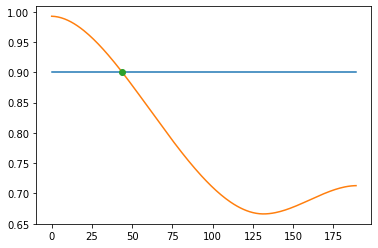

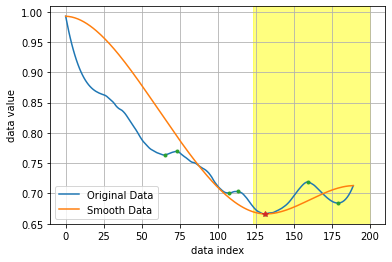

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(118, 0.0009455387853334329), (117, 0.0009455387853334329), (143, 0.000524202449908473), (142, 0.000524202449908473), (127, 0.010987880774316228), (129, 0.010987880774316228), (141, 0.013321097941373483), (139, 0.013321097941373483), (116, 0.031039740620248946), (123, 0.031039740620248946), (100, 0.0037262337425081338), (99, 0.0037262337425081338), (109, 0.0052060813584347), (111, 0.0052060813584347), (75, 0.0019440197983593421), (74, 0.0019440197983593421), (77, 0.005924814269204881), (76, 0.005924814269204881), (98, 0.01122896307789456), (101, 0.01122896307789456), (104, 0.01704180411655365), (106, 0.01704180411655365), (52, 0.00010632140969846215), (51, 0.00010632140969846215), (172, 0.001995724609923366), (173, 0.001995724609923366), (165, 0.0004057897872711269), (166, 0.0004057897872711269), (150, 0.004441972882830103), (148, 0.004441972882830103), (62, 0.027343844260635852), (66, 

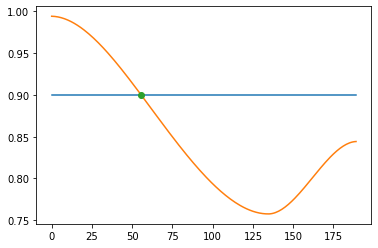

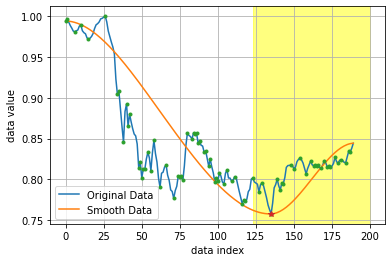

###########Print All Extremas#################
[(172, 0.0033838679732451915), (159, 0.0033838679732451915), (88, 0.00027536866660038406), (87, 0.00027536866660038406), (64, 0.02850792265807678), (92, 0.02850792265807678), (0, 0.013662106934664187), (11, 0.013662106934664187), (126, inf)]
###########Print Filtered Extremas#################
[126]
###########Print Sorted Extremas#################
[(0, 0.013662106934664187), (11, 0.013662106934664187), (64, 0.02850792265807678), (87, 0.00027536866660038406), (88, 0.00027536866660038406), (92, 0.02850792265807678), (126, inf), (159, 0.0033838679732451915), (172, 0.0033838679732451915)]
###########Print Minimas#################
[(0, 0.013662106934664187), (64, 0.02850792265807678), (88, 0.00027536866660038406), (126, inf), (172, 0.0033838679732451915)]
###########Print Maximas#################
[(11, 0.013662106934664187), (87, 0.00027536866660038406), (92, 0.02850792265807678), (159, 0.0033838679732451915)]


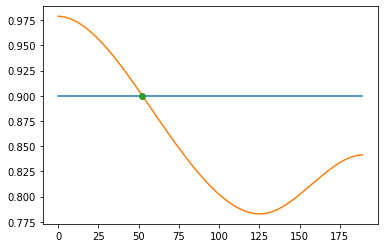

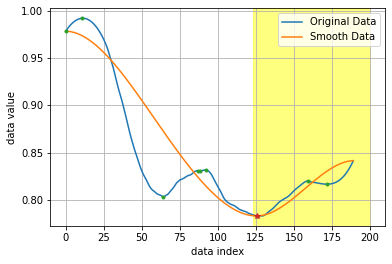

BGS show


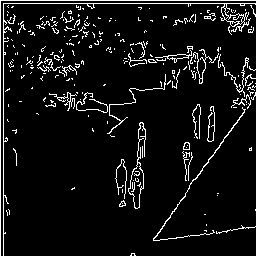

Test case loaded
Test017 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(189, 0.0003392965254814806), (187, 0.0003392965254814806), (182, 0.009704176789494978), (183, 0.009704176789494978), (172, 0.005494632338374217), (171, 0.005494632338374217), (178, 0.0013473011122157041), (179, 0.0013473011122157041), (170, 0.023764289776956327), (175, 0.023764289776956327), (167, 0.01266485838636), (168, 0.01266485838636), (163, 0.000640408807947912), (164, 0.000640408807947912), (159, 0.014855924796007947), (161, 0.014855924796007947), (148, 0.0008828786688668266), (147, 0.0008828786688668266), (153, 0.004508922523206227), (154, 0.004508922523206227), (146, 0.022095813106659423), (151, 0.022095813106659423), (141, 0.0024414663445420093), (142, 0.0024414663445420093), (137, 0.00501791546676944), (138, 0.00501791546676944), (135, 0.0014811485258025003), (136, 0.0014811485258025003), (130, 0.0016610102059185783), (132, 0.00166101020

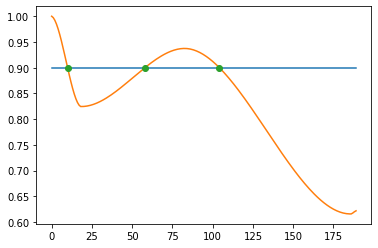

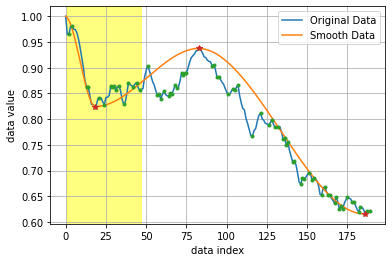

###########Print All Extremas#################
[(55, 0.006723982019190111), (42, 0.006723982019190111), (28, 0.07595200649577716), (87, 0.07595200649577716), (189, inf)]
###########Print Filtered Extremas#################
[189]
###########Print Sorted Extremas#################
[(28, 0.07595200649577716), (42, 0.006723982019190111), (55, 0.006723982019190111), (87, 0.07595200649577716), (189, inf)]
###########Print Minimas#################
[(28, 0.07595200649577716), (55, 0.006723982019190111), (189, inf)]
###########Print Maximas#################
[(42, 0.006723982019190111), (87, 0.07595200649577716)]


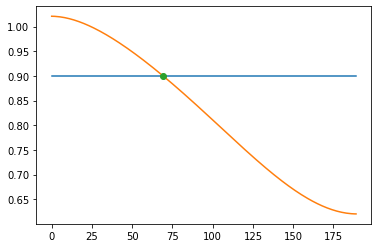

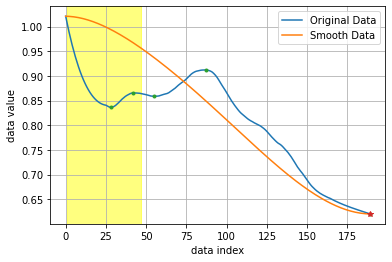

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(182, 0.0012425028474500888), (183, 0.0012425028474500888), (186, 0.0025507999858794816), (185, 0.0025507999858794816), (178, 0.0006602529382495614), (179, 0.0006602529382495614), (175, 0.0005685352356570306), (176, 0.0005685352356570306), (172, 0.003595096849066115), (174, 0.003595096849066115), (167, 0.004488539751610898), (168, 0.004488539751610898), (163, 0.0001675458647374395), (164, 0.0001675458647374395), (159, 0.007509799740402778), (160, 0.007509799740402778), (153, 0.0007383216295787642), (154, 0.0007383216295787642), (146, 0.008578870052126542), (148, 0.008578870052126542), (130, 0.001274794225554543), (129, 0.001274794225554543), (127, 0.009400785670112155), (132, 0.009400785670112155), (116, 0.01309052201785288), (121, 0.01309052201785288), (103, 0.001940121120312499), (104, 0.001940121120312499), (105, 0.006206383792296322), (107, 0.006206383792296322), (57, 0.008746418864

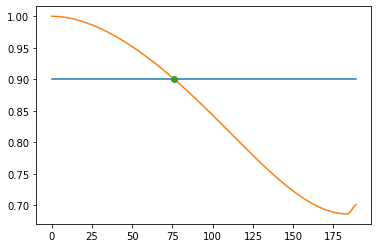

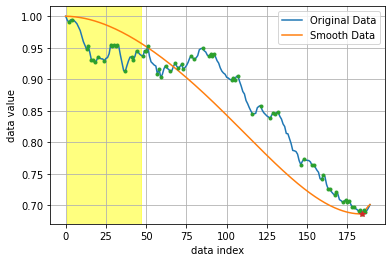

###########Print All Extremas#################
[(83, 1.4002954762837305e-05), (82, 1.4002954762837305e-05), (65, 0.015931964973512014), (84, 0.015931964973512014), (39, 7.065926760407848e-05), (38, 7.065926760407848e-05), (28, 0.004981067336617961), (40, 0.004981067336617961), (185, inf)]
###########Print Filtered Extremas#################
[185]
###########Print Sorted Extremas#################
[(28, 0.004981067336617961), (38, 7.065926760407848e-05), (39, 7.065926760407848e-05), (40, 0.004981067336617961), (65, 0.015931964973512014), (82, 1.4002954762837305e-05), (83, 1.4002954762837305e-05), (84, 0.015931964973512014), (185, inf)]
###########Print Minimas#################
[(28, 0.004981067336617961), (39, 7.065926760407848e-05), (65, 0.015931964973512014), (83, 1.4002954762837305e-05), (185, inf)]
###########Print Maximas#################
[(38, 7.065926760407848e-05), (40, 0.004981067336617961), (82, 1.4002954762837305e-05), (84, 0.015931964973512014)]


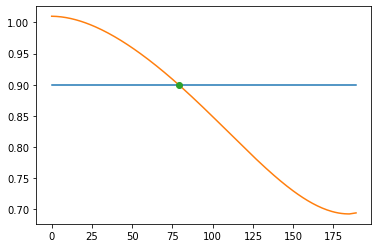

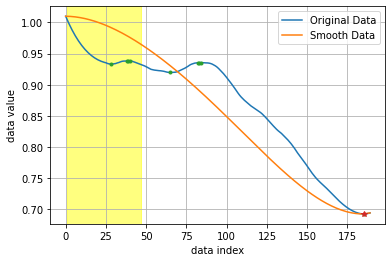

BGS show


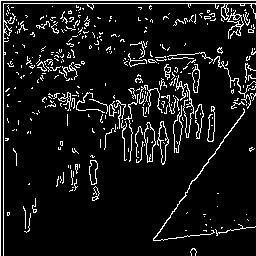

Test case loaded
Test018 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(165, 0.0026951535760321166), (164, 0.0026951535760321166), (167, 0.0033692736028925196), (166, 0.0033692736028925196), (155, 0.008390055313922118), (156, 0.008390055313922118), (172, 0.006696101635840668), (171, 0.006696101635840668), (146, 0.03223518684015014), (151, 0.03223518684015014), (121, 0.0019140996682178724), (120, 0.0019140996682178724), (183, 0.015296492636324932), (181, 0.015296492636324932), (138, 0.013668782033485094), (139, 0.013668782033485094), (187, 0.0010859403540041113), (188, 0.0010859403540041113), (189, 0.0013847275912043377), (185, 0.0013847275912043377), (127, 0.018200452775489095), (124, 0.018200452775489095), (52, 0.006779583386571475), (51, 0.006779583386571475), (131, 0.0033181417127698953), (133, 0.0033181417127698953), (58, 0.005429630442149724), (56, 0.005429630442149724), (117, 0.05149570033049189), (130, 0.0514957

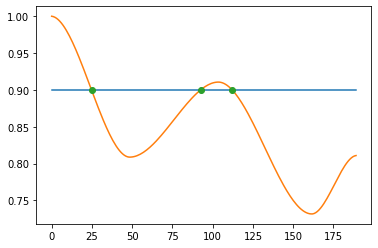

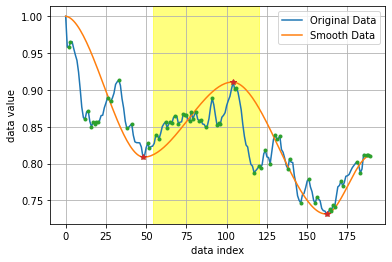

###########Print All Extremas#################
[(133, 0.00011031889465873412), (134, 0.00011031889465873412), (81, 0.0016722030830865764), (74, 0.0016722030830865764), (19, 0.0041988704958856315), (25, 0.0041988704958856315), (55, 0.04624122440840961), (95, 0.04624122440840961), (157, inf)]
###########Print Filtered Extremas#################
[157]
###########Print Sorted Extremas#################
[(19, 0.0041988704958856315), (25, 0.0041988704958856315), (55, 0.04624122440840961), (74, 0.0016722030830865764), (81, 0.0016722030830865764), (95, 0.04624122440840961), (133, 0.00011031889465873412), (134, 0.00011031889465873412), (157, inf)]
###########Print Minimas#################
[(19, 0.0041988704958856315), (55, 0.04624122440840961), (81, 0.0016722030830865764), (133, 0.00011031889465873412), (157, inf)]
###########Print Maximas#################
[(25, 0.0041988704958856315), (74, 0.0016722030830865764), (95, 0.04624122440840961), (134, 0.00011031889465873412)]


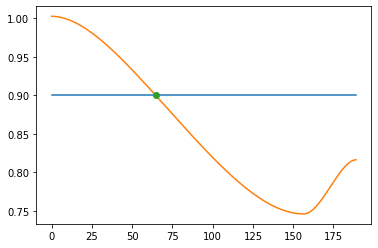

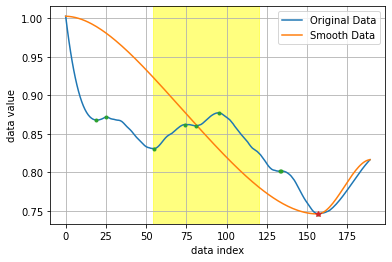

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(165, 0.005218493334951724), (164, 0.005218493334951724), (159, 0.00526668421955212), (161, 0.00526668421955212), (148, 0.00400124553864023), (147, 0.00400124553864023), (154, 0.008591767307531528), (156, 0.008591767307531528), (146, 0.021935107136534016), (151, 0.021935107136534016), (140, 0.002886563801221098), (139, 0.002886563801221098), (137, 0.012743138999167125), (141, 0.012743138999167125), (172, 0.0006947208578590436), (171, 0.0006947208578590436), (125, 0.0012225922737953976), (126, 0.0012225922737953976), (184, 0.011949664547373784), (186, 0.011949664547373784), (175, 7.317185812527605e-05), (174, 7.317185812527605e-05), (179, 0.007134234855956656), (181, 0.007134234855956656), (117, 0.002624446974875627), (119, 0.002624446974875627), (121, 0.008274322049391603), (124, 0.008274322049391603), (189, 0.022628046071069052), (177, 0.022628046071069052), (115, 0.0009822649515344173

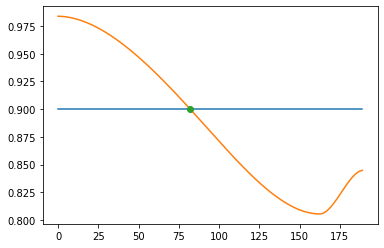

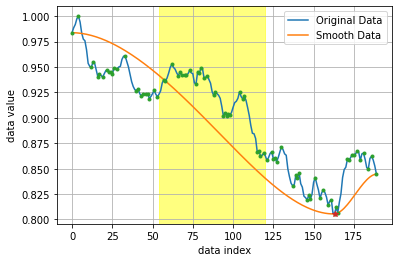

###########Print All Extremas#################
[(189, 0.007340845661634954), (182, 0.007340845661634954), (50, 0.016807114299734027), (72, 0.016807114299734027), (154, inf)]
###########Print Filtered Extremas#################
[154]
###########Print Sorted Extremas#################
[(50, 0.016807114299734027), (72, 0.016807114299734027), (154, inf), (182, 0.007340845661634954), (189, 0.007340845661634954)]
###########Print Minimas#################
[(50, 0.016807114299734027), (154, inf), (189, 0.007340845661634954)]
###########Print Maximas#################
[(72, 0.016807114299734027), (182, 0.007340845661634954)]


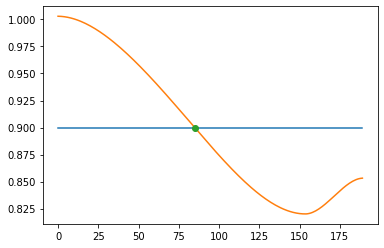

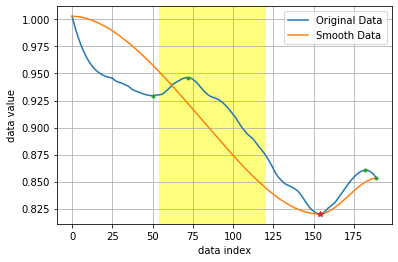

BGS show


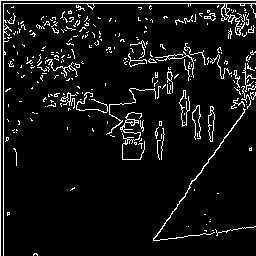

Test case loaded
Test019 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(119, 0.006952616132240408), (120, 0.006952616132240408), (126, 0.03488367978758444), (125, 0.03488367978758444), (115, 0.005294991072319899), (116, 0.005294991072319899), (105, 0.003234708294627464), (106, 0.003234708294627464), (107, 0.010895878416002147), (108, 0.010895878416002147), (101, 0.004765030622061461), (102, 0.004765030622061461), (81, 0.002632518711680909), (80, 0.002632518711680909), (71, 0.018581826345551944), (73, 0.018581826345551944), (68, 0.0021274014553657183), (69, 0.0021274014553657183), (65, 0.03523943640923255), (67, 0.03523943640923255), (86, 0.015271501334915283), (84, 0.015271501334915283), (60, 0.01882169546736645), (62, 0.01882169546736645), (90, 0.013148023400457287), (88, 0.013148023400457287), (77, 0.09739744177577259), (92, 0.09739744177577259), (21, 0.0012639398558403903), (20, 0.0012639398558403903), (14, 0.015546

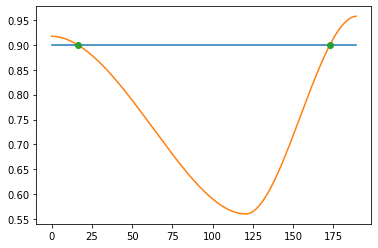

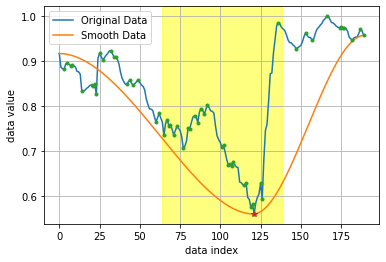

###########Print All Extremas#################
[(86, 0.0005145352665422154), (85, 0.0005145352665422154), (72, 0.019440894294359023), (88, 0.019440894294359023), (13, 0.025323177065100233), (35, 0.025323177065100233), (158, 0.011923034149674883), (150, 0.011923034149674883), (189, 0.04157228794837742), (174, 0.04157228794837742), (114, inf)]
###########Print Filtered Extremas#################
[114]
###########Print Sorted Extremas#################
[(13, 0.025323177065100233), (35, 0.025323177065100233), (72, 0.019440894294359023), (85, 0.0005145352665422154), (86, 0.0005145352665422154), (88, 0.019440894294359023), (114, inf), (150, 0.011923034149674883), (158, 0.011923034149674883), (174, 0.04157228794837742), (189, 0.04157228794837742)]
###########Print Minimas#################
[(13, 0.025323177065100233), (72, 0.019440894294359023), (86, 0.0005145352665422154), (114, inf), (158, 0.011923034149674883), (189, 0.04157228794837742)]
###########Print Maximas#################
[(35, 0.0253

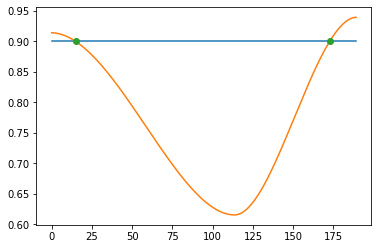

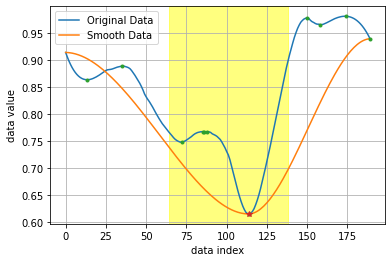

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(117, 0.009677081590812153), (118, 0.009677081590812153), (119, 0.016650227830357744), (120, 0.016650227830357744), (124, 0.002756957824359141), (123, 0.002756957824359141), (114, 0.00993748300530739), (116, 0.00993748300530739), (126, 0.057022632136588536), (125, 0.057022632136588536), (107, 0.0034453122808171255), (108, 0.0034453122808171255), (105, 0.005811551472283738), (106, 0.005811551472283738), (101, 0.0007075866789498786), (102, 0.0007075866789498786), (129, 0.0004157210008153278), (128, 0.0004157210008153278), (98, 0.001201899957492647), (99, 0.001201899957492647), (73, 0.00019124165388895165), (72, 0.00019124165388895165), (71, 0.004818358430376257), (75, 0.004818358430376257), (81, 0.001286783373889322), (80, 0.001286783373889322), (90, 0.01027701470613196), (88, 0.01027701470613196), (68, 0.011925699261424283), (70, 0.011925699261424283), (65, 0.016566534836657043), (67, 0.

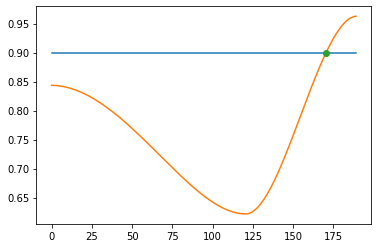

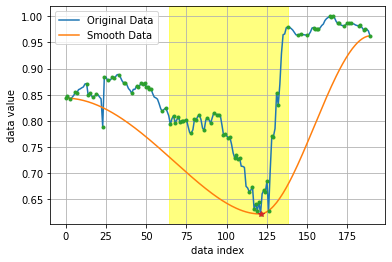

###########Print All Extremas#################
[(86, 0.00031371112210676344), (88, 0.00031371112210676344), (74, 0.0037103120386781097), (84, 0.0037103120386781097), (1, 0.02615876284800578), (40, 0.02615876284800578), (160, 0.007970647143739629), (173, 0.007970647143739629), (189, 0.03209552642692026), (151, 0.03209552642692026), (115, inf)]
###########Print Filtered Extremas#################
[115]
###########Print Sorted Extremas#################
[(1, 0.02615876284800578), (40, 0.02615876284800578), (74, 0.0037103120386781097), (84, 0.0037103120386781097), (86, 0.00031371112210676344), (88, 0.00031371112210676344), (115, inf), (151, 0.03209552642692026), (160, 0.007970647143739629), (173, 0.007970647143739629), (189, 0.03209552642692026)]
###########Print Minimas#################
[(1, 0.02615876284800578), (74, 0.0037103120386781097), (86, 0.00031371112210676344), (115, inf), (160, 0.007970647143739629), (189, 0.03209552642692026)]
###########Print Maximas#################
[(40, 0.02

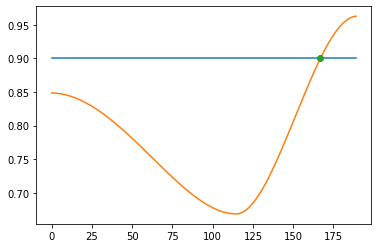

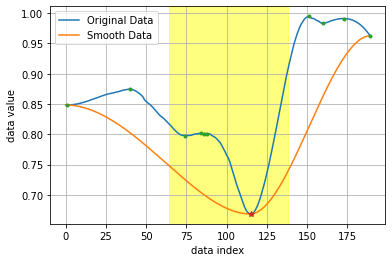

BGS show


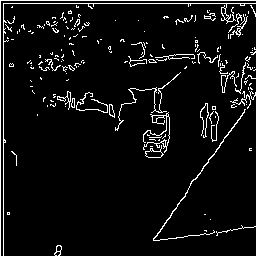

Test case loaded
Test020 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(62, 0.0037169815117652494), (61, 0.0037169815117652494), (70, 0.00020691455299903794), (69, 0.00020691455299903794), (79, 0.00406183641932234), (78, 0.00406183641932234), (85, 0.0038035684604199593), (84, 0.0038035684604199593), (92, 0.004125048150485533), (90, 0.004125048150485533), (96, 0.004361303087793922), (95, 0.004361303087793922), (102, 0.004460015118231242), (100, 0.004460015118231242), (109, 0.004702870772749446), (108, 0.004702870772749446), (112, 0.006244654334787603), (110, 0.006244654334787603), (105, 0.011717441002224604), (104, 0.011717441002224604), (136, 0.0017410810344253846), (135, 0.0017410810344253846), (125, 0.020124704388551296), (127, 0.020124704388551296), (139, 0.003771925582626623), (138, 0.003771925582626623), (115, 0.007438091560376003), (114, 0.007438091560376003), (118, 0.012119944593522503), (117, 0.0121199445935225

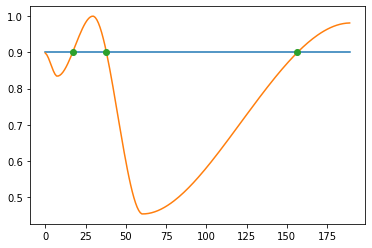

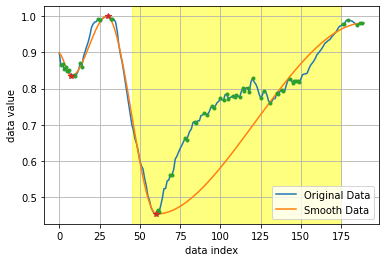

###########Print All Extremas#################
[(127, 7.105978900645571e-05), (126, 7.105978900645571e-05), (131, 1.1299994641222888e-05), (130, 1.1299994641222888e-05), (123, 0.0027606893795547593), (115, 0.0027606893795547593), (4, 0.1287277129851161), (26, 0.1287277129851161), (189, 0.013899923820400062), (182, 0.013899923820400062), (61, inf)]
###########Print Filtered Extremas#################
[4, 26, 61]
###########Print Sorted Extremas#################
[(4, 0.1287277129851161), (26, 0.1287277129851161), (61, inf), (115, 0.0027606893795547593), (123, 0.0027606893795547593), (126, 7.105978900645571e-05), (127, 7.105978900645571e-05), (130, 1.1299994641222888e-05), (131, 1.1299994641222888e-05), (182, 0.013899923820400062), (189, 0.013899923820400062)]
###########Print Minimas#################
[(4, 0.1287277129851161), (61, inf), (123, 0.0027606893795547593), (127, 7.105978900645571e-05), (131, 1.1299994641222888e-05), (189, 0.013899923820400062)]
###########Print Maximas##########

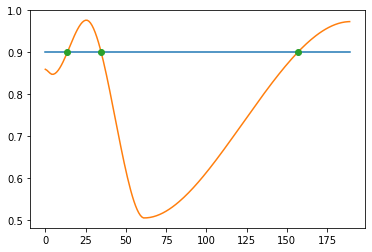

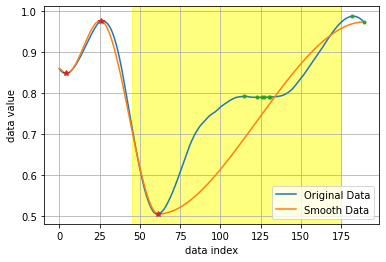

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(61, 0.05458296184854128), (63, 0.05458296184854128), (57, 0.005354872820001688), (58, 0.005354872820001688), (66, 0.038657376197527515), (65, 0.038657376197527515), (69, 0.001966839639266027), (68, 0.001966839639266027), (50, 0.007278912811668592), (51, 0.007278912811668592), (75, 0.012970707522719782), (74, 0.012970707522719782), (78, 0.013843306940066968), (77, 0.013843306940066968), (82, 2.1510853238648764e-06), (81, 2.1510853238648764e-06), (85, 0.0068921938907068325), (84, 0.0068921938907068325), (93, 0.006430041548694532), (92, 0.006430041548694532), (137, 0.0018442653232529915), (135, 0.0018442653232529915), (130, 0.003220461065430391), (132, 0.003220461065430391), (107, 0.0006250066768284102), (106, 0.0006250066768284102), (99, 0.004693636968698622), (98, 0.004693636968698622), (140, 0.006865121273563757), (138, 0.006865121273563757), (102, 0.003997234992611509), (103, 0.003997

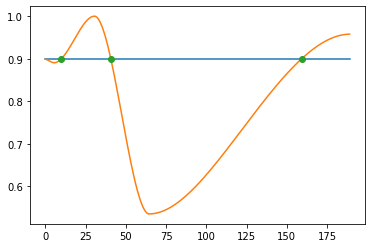

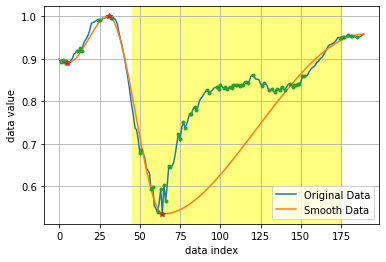

###########Print All Extremas#################
[(138, 0.0119773050540265), (110, 0.0119773050540265), (189, 0.012438214866188901), (182, 0.012438214866188901), (3, 0.1034394635195911), (26, 0.1034394635195911), (62, inf)]
###########Print Filtered Extremas#################
[3, 26, 62]
###########Print Sorted Extremas#################
[(3, 0.1034394635195911), (26, 0.1034394635195911), (62, inf), (110, 0.0119773050540265), (138, 0.0119773050540265), (182, 0.012438214866188901), (189, 0.012438214866188901)]
###########Print Minimas#################
[(3, 0.1034394635195911), (62, inf), (138, 0.0119773050540265), (189, 0.012438214866188901)]
###########Print Maximas#################
[(26, 0.1034394635195911), (110, 0.0119773050540265), (182, 0.012438214866188901)]


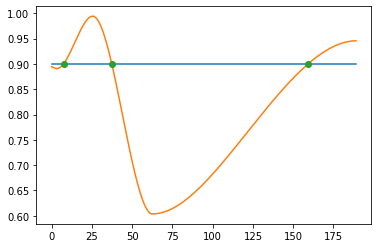

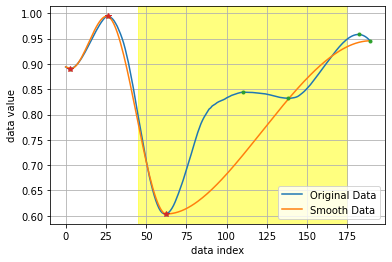

BGS show


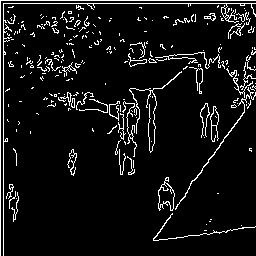

Test case loaded
Test021 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(33, 0.004277618820667239), (32, 0.004277618820667239), (100, 0.0023090238429651633), (101, 0.0023090238429651633), (160, 0.000725965217385105), (159, 0.000725965217385105), (53, 0.004329916402388001), (54, 0.004329916402388001), (61, 0.006542287939686808), (58, 0.006542287939686808), (95, 0.0009104972588034332), (96, 0.0009104972588034332), (73, 0.006706947002005581), (75, 0.006706947002005581), (48, 0.013798472315988741), (51, 0.013798472315988741), (46, 0.012208775060875365), (47, 0.012208775060875365), (68, 0.010875787613174648), (70, 0.010875787613174648), (140, 0.003911945262078942), (141, 0.003911945262078942), (77, 0.03535468117794449), (65, 0.03535468117794449), (144, 0.017938005581069505), (138, 0.017938005581069505), (135, 0.02332548857716621), (147, 0.02332548857716621), (83, 0.0018627844859979703), (84, 0.0018627844859979703), (186, 0.0

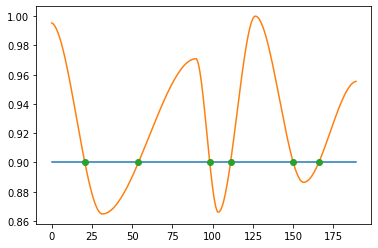

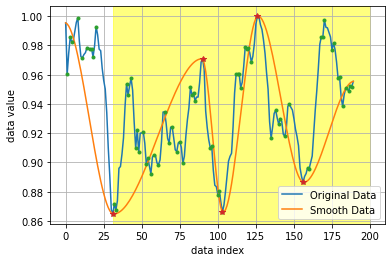

###########Print All Extremas#################
[(45, 0.012864719912665468), (54, 0.012864719912665468), (103, 0.024852403583244476), (80, 0.024852403583244476), (150, 0.0628463419273958), (126, 0.0628463419273958), (189, 0.044262624658744865), (178, 0.044262624658744865), (0, 0.015336152477865905), (7, 0.015336152477865905), (65, inf)]
###########Print Filtered Extremas#################
[65]
###########Print Sorted Extremas#################
[(0, 0.015336152477865905), (7, 0.015336152477865905), (45, 0.012864719912665468), (54, 0.012864719912665468), (65, inf), (80, 0.024852403583244476), (103, 0.024852403583244476), (126, 0.0628463419273958), (150, 0.0628463419273958), (178, 0.044262624658744865), (189, 0.044262624658744865)]
###########Print Minimas#################
[(0, 0.015336152477865905), (45, 0.012864719912665468), (65, inf), (103, 0.024852403583244476), (150, 0.0628463419273958), (189, 0.044262624658744865)]
###########Print Maximas#################
[(7, 0.015336152477865905), 

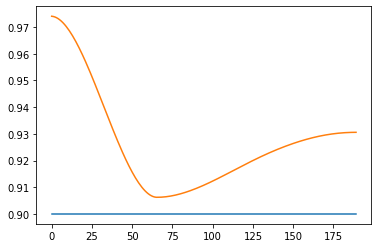

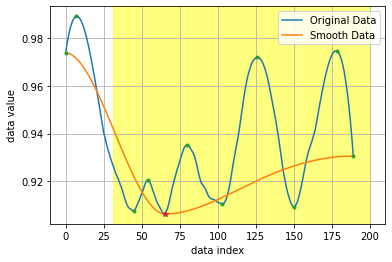

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(56, 0.0025662168872881974), (54, 0.0025662168872881974), (60, 0.0006473558906211485), (61, 0.0006473558906211485), (62, 0.0011264371340805601), (59, 0.0011264371340805601), (73, 1.4069452774712055e-05), (74, 1.4069452774712055e-05), (48, 0.00711808732807373), (47, 0.00711808732807373), (67, 0.008098006040057282), (65, 0.008098006040057282), (31, 0.004337140140856066), (32, 0.004337140140856066), (46, 0.017349250783855963), (49, 0.017349250783855963), (77, 0.017740375206592662), (70, 0.017740375206592662), (42, 0.00077074066250582), (43, 0.00077074066250582), (85, 0.0024480544012664973), (84, 0.0024480544012664973), (34, 0.029187328268676094), (40, 0.029187328268676094), (166, 0.00030035436160991136), (165, 0.00030035436160991136), (152, 0.00010875043084468405), (153, 0.00010875043084468405), (4, 0.005735542370778002), (2, 0.005735542370778002), (150, 0.0006979914625169226), (151, 0.000

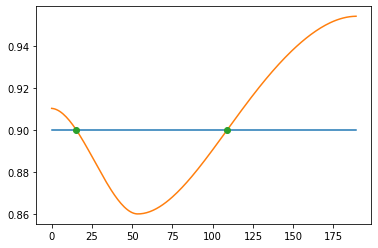

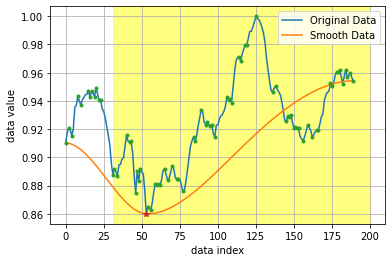

###########Print All Extremas#################
[(50, 0.0004902420883247105), (53, 0.0004902420883247105), (0, 0.0377494896239603), (13, 0.0377494896239603), (189, 0.0014236591484072525), (186, 0.0014236591484072525), (154, 0.06559638898795672), (123, 0.06559638898795672), (64, inf)]
###########Print Filtered Extremas#################
[64]
###########Print Sorted Extremas#################
[(0, 0.0377494896239603), (13, 0.0377494896239603), (50, 0.0004902420883247105), (53, 0.0004902420883247105), (64, inf), (123, 0.06559638898795672), (154, 0.06559638898795672), (186, 0.0014236591484072525), (189, 0.0014236591484072525)]
###########Print Minimas#################
[(0, 0.0377494896239603), (50, 0.0004902420883247105), (64, inf), (154, 0.06559638898795672), (189, 0.0014236591484072525)]
###########Print Maximas#################
[(13, 0.0377494896239603), (53, 0.0004902420883247105), (123, 0.06559638898795672), (186, 0.0014236591484072525)]


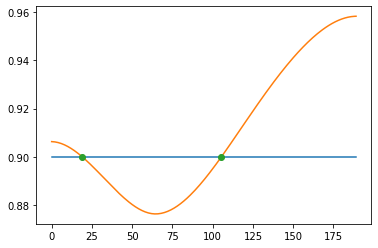

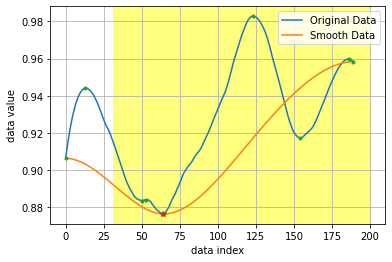

BGS show


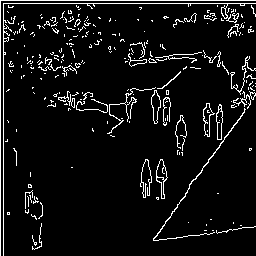

Test case loaded
Test022 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(187, 0.0003655499434193077), (186, 0.0003655499434193077), (176, 0.0013757494579518248), (175, 0.0013757494579518248), (174, 0.03092948254062977), (180, 0.03092948254062977), (16, 0.008735603138553816), (14, 0.008735603138553816), (9, 0.012074031389912698), (10, 0.012074031389912698), (4, 0.009596056163671984), (6, 0.009596056163671984), (65, 0.005280963590931442), (62, 0.005280963590931442), (23, 0.002312393542928892), (24, 0.002312393542928892), (55, 0.017353947385193358), (57, 0.017353947385193358), (25, 0.005466301357403114), (21, 0.005466301357403114), (27, 0.0034086774479725745), (26, 0.0034086774479725745), (31, 0.0115346599536289), (28, 0.0115346599536289), (70, 0.0005570645668246943), (71, 0.0005570645668246943), (72, 0.004804669862386479), (67, 0.004804669862386479), (139, 0.008943583619518747), (141, 0.008943583619518747), (37, 0.0050805

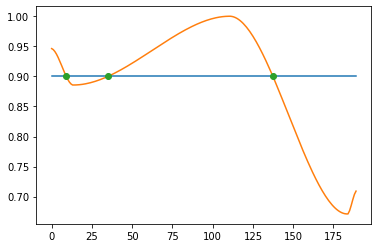

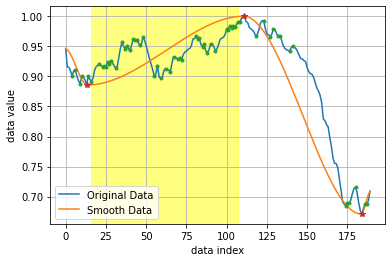

###########Print All Extremas#################
[(39, 8.618351461042728e-05), (38, 8.618351461042728e-05), (60, 0.02543705924630213), (40, 0.02543705924630213), (12, 0.09005672153908728), (114, 0.09005672153908728), (182, inf)]
###########Print Filtered Extremas#################
[182]
###########Print Sorted Extremas#################
[(12, 0.09005672153908728), (38, 8.618351461042728e-05), (39, 8.618351461042728e-05), (40, 0.02543705924630213), (60, 0.02543705924630213), (114, 0.09005672153908728), (182, inf)]
###########Print Minimas#################
[(12, 0.09005672153908728), (39, 8.618351461042728e-05), (60, 0.02543705924630213), (182, inf)]
###########Print Maximas#################
[(38, 8.618351461042728e-05), (40, 0.02543705924630213), (114, 0.09005672153908728)]


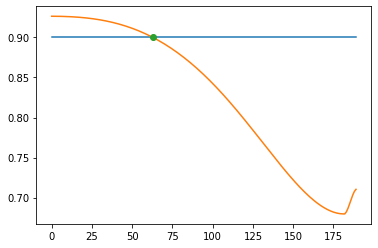

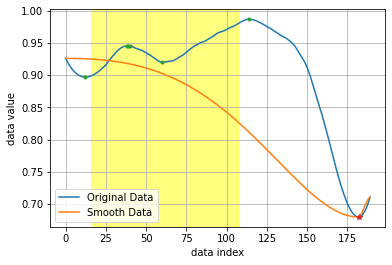

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(184, 0.011112270998730911), (181, 0.011112270998730911), (167, 0.001318682554244388), (168, 0.001318682554244388), (160, 0.006358772927422485), (161, 0.006358772927422485), (146, 0.0012338173618013926), (148, 0.0012338173618013926), (25, 0.003404221477946945), (26, 0.003404221477946945), (23, 0.0011832216553842034), (24, 0.0011832216553842034), (60, 0.0006744018044630984), (59, 0.0006744018044630984), (27, 0.005159489870071754), (28, 0.005159489870071754), (63, 0.003653678954830819), (61, 0.003653678954830819), (82, 0.0007528760895854081), (83, 0.0007528760895854081), (65, 0.006898473239577263), (64, 0.006898473239577263), (20, 0.006031137644277429), (21, 0.006031137644277429), (84, 0.00496186897667672), (86, 0.00496186897667672), (16, 0.005024231331833162), (14, 0.005024231331833162), (13, 0.008630558000012445), (10, 0.008630558000012445), (71, 0.00010188528141519271), (70, 0.00010188

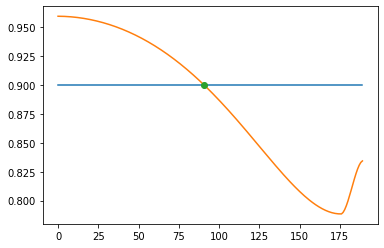

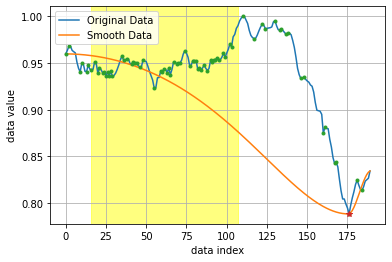

###########Print All Extremas#################
[(51, 3.404387448446844e-05), (52, 3.404387448446844e-05), (39, 7.732642553015534e-05), (40, 7.732642553015534e-05), (57, 0.005128140799327885), (33, 0.005128140799327885), (84, 0.0013901042295971777), (79, 0.0013901042295971777), (21, 0.05169170457000638), (122, 0.05169170457000638), (179, inf)]
###########Print Filtered Extremas#################
[179]
###########Print Sorted Extremas#################
[(21, 0.05169170457000638), (33, 0.005128140799327885), (39, 7.732642553015534e-05), (40, 7.732642553015534e-05), (51, 3.404387448446844e-05), (52, 3.404387448446844e-05), (57, 0.005128140799327885), (79, 0.0013901042295971777), (84, 0.0013901042295971777), (122, 0.05169170457000638), (179, inf)]
###########Print Minimas#################
[(21, 0.05169170457000638), (39, 7.732642553015534e-05), (51, 3.404387448446844e-05), (57, 0.005128140799327885), (84, 0.0013901042295971777), (179, inf)]
###########Print Maximas#################
[(33, 0.00

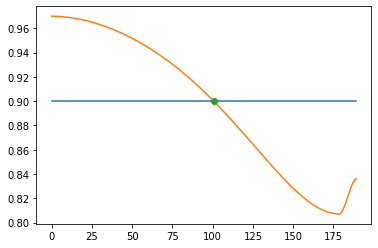

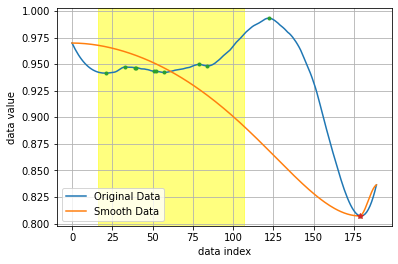

BGS show


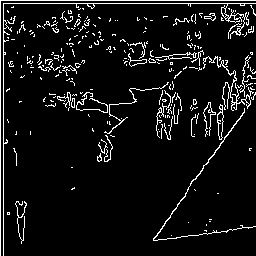

Test case loaded
Test023 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(13, 0.009542374018366884), (15, 0.009542374018366884), (6, 0.0012800084299385839), (7, 0.0012800084299385839), (8, 0.005639679113846996), (10, 0.005639679113846996), (2, 0.004879662921231875), (3, 0.004879662921231875), (113, 0.0028413958378418203), (112, 0.0028413958378418203), (181, 0.017836679287768664), (183, 0.017836679287768664), (80, 0.008486291559636538), (79, 0.008486291559636538), (84, 0.004522932177693395), (82, 0.004522932177693395), (86, 4.122397699535263e-06), (85, 4.122397699535263e-06), (59, 0.003344357962636435), (60, 0.003344357962636435), (46, 0.001571096524522697), (45, 0.001571096524522697), (44, 0.005199904463843885), (43, 0.005199904463843885), (88, 0.001729208896641854), (87, 0.001729208896641854), (148, 0.0018262178391510453), (149, 0.0018262178391510453), (49, 0.0014373313498914353), (48, 0.0014373313498914353), (174, 0.00

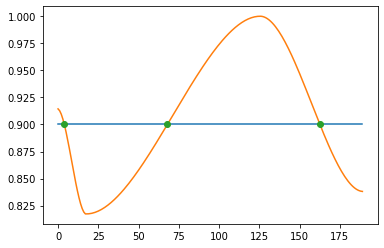

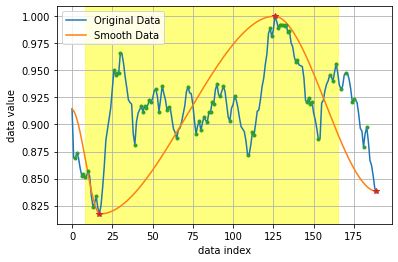

###########Print All Extremas#################
[(54, 0.0002008962302494366), (52, 0.0002008962302494366), (51, 0.0030507073591939937), (60, 0.0030507073591939937), (71, 0.012005077601760616), (88, 0.012005077601760616), (103, 0.029280025876534777), (40, 0.029280025876534777), (154, 0.009739950940315989), (169, 0.009739950940315989), (10, 0.13266516915718685), (131, 0.13266516915718685), (189, inf)]
###########Print Filtered Extremas#################
[10, 131, 189]
###########Print Sorted Extremas#################
[(10, 0.13266516915718685), (40, 0.029280025876534777), (51, 0.0030507073591939937), (52, 0.0002008962302494366), (54, 0.0002008962302494366), (60, 0.0030507073591939937), (71, 0.012005077601760616), (88, 0.012005077601760616), (103, 0.029280025876534777), (131, 0.13266516915718685), (154, 0.009739950940315989), (169, 0.009739950940315989), (189, inf)]
###########Print Minimas#################
[(10, 0.13266516915718685), (51, 0.0030507073591939937), (54, 0.0002008962302494366)

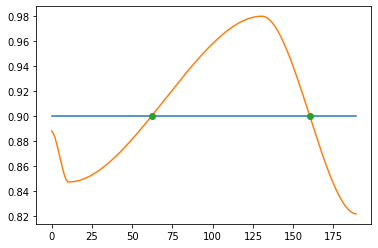

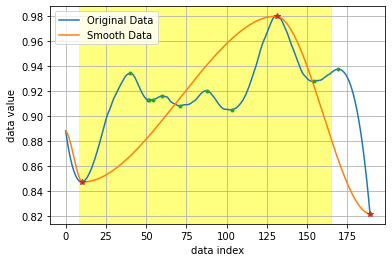

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(185, 0.00036237626585700067), (186, 0.00036237626585700067), (181, 0.009921453359240995), (183, 0.009921453359240995), (165, 0.003266029164253448), (164, 0.003266029164253448), (14, 0.0021540742039544147), (15, 0.0021540742039544147), (109, 0.0013970127137179489), (108, 0.0013970127137179489), (8, 0.001435812354361854), (7, 0.001435812354361854), (174, 0.0010212870999398715), (175, 0.0010212870999398715), (4, 0.015298777551621567), (10, 0.015298777551621567), (88, 0.0006877283461290684), (89, 0.0006877283461290684), (98, 0.010951729010194589), (102, 0.010951729010194589), (171, 0.004793968606072729), (173, 0.004793968606072729), (163, 0.042484527247463655), (170, 0.042484527247463655), (86, 0.004084136069765543), (87, 0.004084136069765543), (92, 0.011235750278685064), (95, 0.011235750278685064), (154, 0.027540026309344934), (155, 0.027540026309344934), (148, 0.0023416224287156062), (14

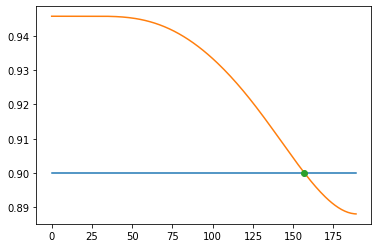

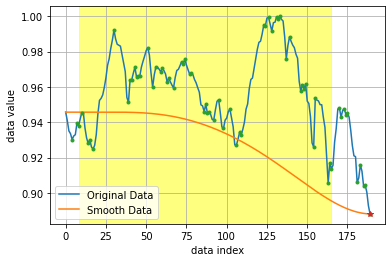

###########Print All Extremas#################
[(54, 0.0041693403814718755), (63, 0.0041693403814718755), (99, 0.038944642257604745), (41, 0.038944642257604745), (7, 0.061687500921507876), (130, 0.061687500921507876), (189, inf)]
###########Print Filtered Extremas#################
[189]
###########Print Sorted Extremas#################
[(7, 0.061687500921507876), (41, 0.038944642257604745), (54, 0.0041693403814718755), (63, 0.0041693403814718755), (99, 0.038944642257604745), (130, 0.061687500921507876), (189, inf)]
###########Print Minimas#################
[(7, 0.061687500921507876), (54, 0.0041693403814718755), (99, 0.038944642257604745), (189, inf)]
###########Print Maximas#################
[(41, 0.038944642257604745), (63, 0.0041693403814718755), (130, 0.061687500921507876)]


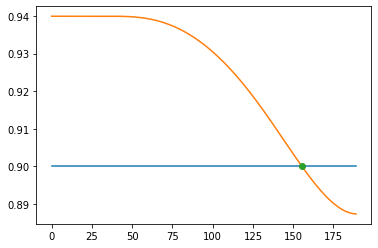

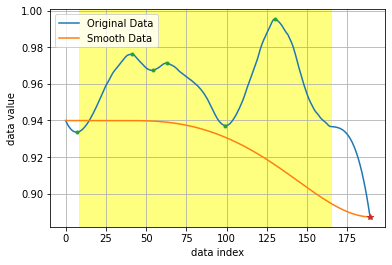

BGS show


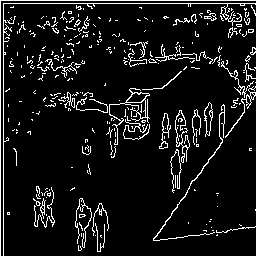

Test case loaded
Test024 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(151, 0.036981551711865235), (153, 0.036981551711865235), (146, 0.022195104446746106), (148, 0.022195104446746106), (142, 0.0247010359976646), (143, 0.0247010359976646), (139, 0.002040472766793422), (140, 0.002040472766793422), (137, 0.002983916998826275), (138, 0.002983916998826275), (130, 0.0075302966168657726), (132, 0.0075302966168657726), (127, 0.0028471326606388514), (126, 0.0028471326606388514), (134, 0.01841306966321299), (136, 0.01841306966321299), (125, 0.011315300381994131), (128, 0.011315300381994131), (119, 0.041902469946986654), (121, 0.041902469946986654), (114, 0.004055934542617323), (115, 0.004055934542617323), (94, 0.0035841508548093426), (92, 0.0035841508548093426), (103, 0.004076863449557155), (105, 0.004076863449557155), (87, 0.0013573224456383537), (88, 0.0013573224456383537), (99, 0.024767065764345064), (96, 0.0247670657643450

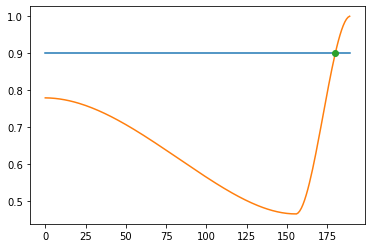

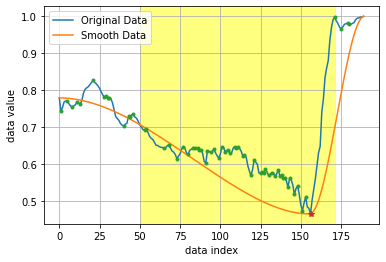

###########Print All Extremas#################
[(79, 0.00048785730497435953), (82, 0.00048785730497435953), (87, 0.006841879250510163), (95, 0.006841879250510163), (0, 0.06387080671850986), (16, 0.06387080671850986), (189, 0.1120814120592224), (181, 0.1120814120592224), (146, inf)]
###########Print Filtered Extremas#################
[146, 181, 189]
###########Print Sorted Extremas#################
[(0, 0.06387080671850986), (16, 0.06387080671850986), (79, 0.00048785730497435953), (82, 0.00048785730497435953), (87, 0.006841879250510163), (95, 0.006841879250510163), (146, inf), (181, 0.1120814120592224), (189, 0.1120814120592224)]
###########Print Minimas#################
[(0, 0.06387080671850986), (79, 0.00048785730497435953), (87, 0.006841879250510163), (146, inf), (189, 0.1120814120592224)]
###########Print Maximas#################
[(16, 0.06387080671850986), (82, 0.00048785730497435953), (95, 0.006841879250510163), (181, 0.1120814120592224)]


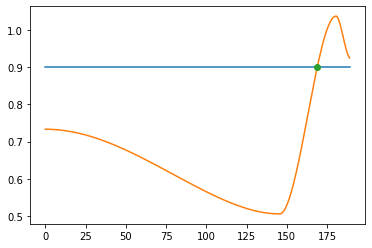

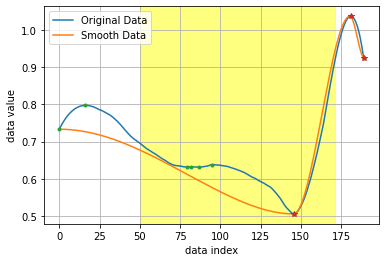

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(151, 0.020087831399545175), (153, 0.020087831399545175), (146, 0.006404322013961794), (147, 0.006404322013961794), (142, 0.009061669233878078), (143, 0.009061669233878078), (130, 0.0008984670559167851), (131, 0.0008984670559167851), (125, 0.002572915780146512), (126, 0.002572915780146512), (127, 0.011069664373727695), (128, 0.011069664373727695), (119, 0.016912875991520027), (121, 0.016912875991520027), (138, 0.011962552053777942), (140, 0.011962552053777942), (134, 0.03331104980624344), (136, 0.03331104980624344), (106, 0.0002840108781166917), (105, 0.0002840108781166917), (95, 0.005087311453069954), (96, 0.005087311453069954), (114, 0.00022112338622737315), (115, 0.00022112338622737315), (91, 0.012307582747776769), (92, 0.012307582747776769), (104, 0.0116129405209624), (101, 0.0116129405209624), (80, 0.011728621495789904), (77, 0.011728621495789904), (85, 0.0018639912867922659), (84,

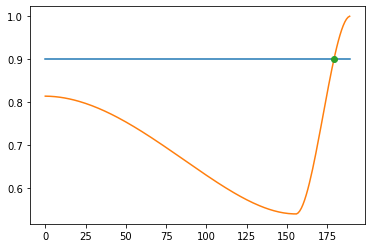

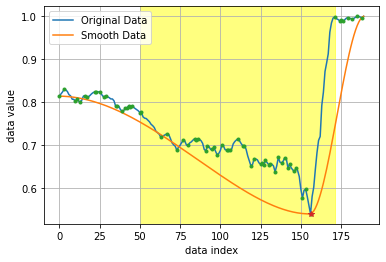

###########Print All Extremas#################
[(90, 0.0037661096651162573), (95, 0.0037661096651162573), (189, 0.10297430560570464), (181, 0.10297430560570464), (146, inf)]
###########Print Filtered Extremas#################
[146, 181, 189]
###########Print Sorted Extremas#################
[(90, 0.0037661096651162573), (95, 0.0037661096651162573), (146, inf), (181, 0.10297430560570464), (189, 0.10297430560570464)]
###########Print Minimas#################
[(90, 0.0037661096651162573), (146, inf), (189, 0.10297430560570464)]
###########Print Maximas#################
[(95, 0.0037661096651162573), (181, 0.10297430560570464)]


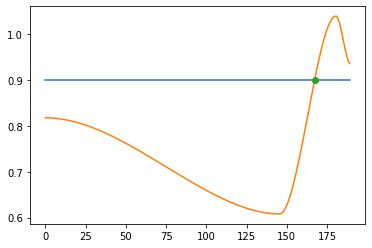

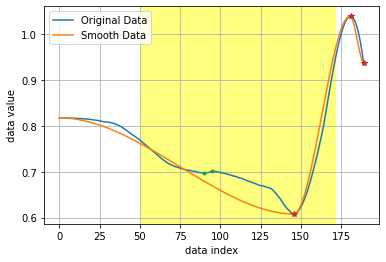

BGS show


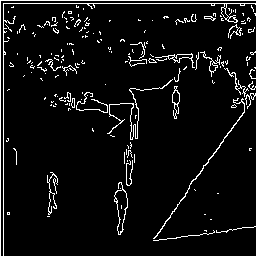

Test case loaded
Test025 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(114, 0.010204297936803886), (115, 0.010204297936803886), (103, 0.03448452088695009), (106, 0.03448452088695009), (23, 0.0050073527858764955), (24, 0.0050073527858764955), (82, 0.0011256226980111972), (83, 0.0011256226980111972), (37, 0.0007664560776315943), (38, 0.0007664560776315943), (84, 0.013483739168231978), (80, 0.013483739168231978), (92, 0.0190386003858245), (95, 0.0190386003858245), (88, 0.0023910099632398207), (89, 0.0023910099632398207), (2, 0.004579085149195916), (3, 0.004579085149195916), (78, 0.024036945272681298), (87, 0.024036945272681298), (74, 0.009416931362934311), (75, 0.009416931362934311), (71, 0.014918095004996301), (72, 0.014918095004996301), (40, 0.03409342073424304), (32, 0.03409342073424304), (47, 0.005961473088134661), (46, 0.005961473088134661), (65, 0.010141888139924449), (67, 0.010141888139924449), (12, 0.004817316145

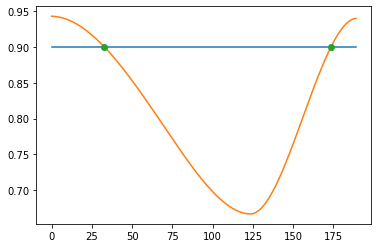

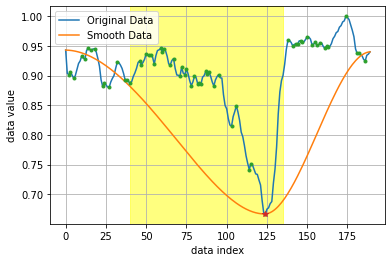

###########Print All Extremas#################
[(0, 0.025738117646942338), (11, 0.025738117646942338), (56, 0.00018774657625209024), (54, 0.00018774657625209024), (35, 0.029502654977498266), (59, 0.029502654977498266), (162, 0.00016809196310141328), (161, 0.00016809196310141328), (158, 0.004304908523361406), (152, 0.004304908523361406), (189, 0.05615075446814366), (172, 0.05615075446814366), (118, inf)]
###########Print Filtered Extremas#################
[118]
###########Print Sorted Extremas#################
[(0, 0.025738117646942338), (11, 0.025738117646942338), (35, 0.029502654977498266), (54, 0.00018774657625209024), (56, 0.00018774657625209024), (59, 0.029502654977498266), (118, inf), (152, 0.004304908523361406), (158, 0.004304908523361406), (161, 0.00016809196310141328), (162, 0.00016809196310141328), (172, 0.05615075446814366), (189, 0.05615075446814366)]
###########Print Minimas#################
[(0, 0.025738117646942338), (35, 0.029502654977498266), (56, 0.00018774657625209024

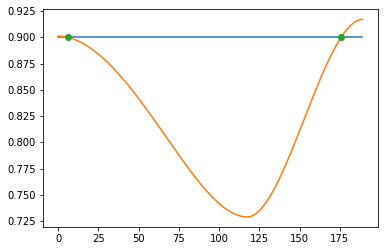

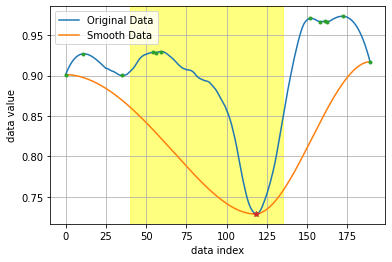

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(118, 0.0015331763222986572), (119, 0.0015331763222986572), (126, 0.0036569363537755084), (125, 0.0036569363537755084), (120, 0.004250539422506527), (121, 0.004250539422506527), (114, 0.012635389464058067), (116, 0.012635389464058067), (101, 0.0029014977777082063), (102, 0.0029014977777082063), (103, 0.017806114427904585), (105, 0.017806114427904585), (90, 0.00880470721536697), (89, 0.00880470721536697), (84, 0.02125292564892778), (80, 0.02125292564892778), (73, 0.0176379834237127), (75, 0.0176379834237127), (69, 0.0027894379581941964), (70, 0.0027894379581941964), (78, 0.034135058195078116), (94, 0.034135058195078116), (64, 0.009683229724104958), (67, 0.009683229724104958), (32, 0.0006017807360140237), (31, 0.0006017807360140237), (60, 0.0017463148273694218), (61, 0.0017463148273694218), (44, 0.001830060778963638), (42, 0.001830060778963638), (37, 0.005413140169385433), (38, 0.00541314

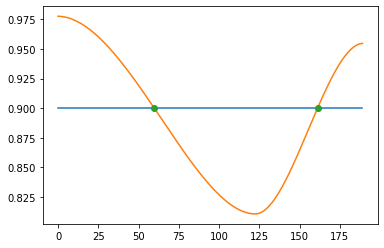

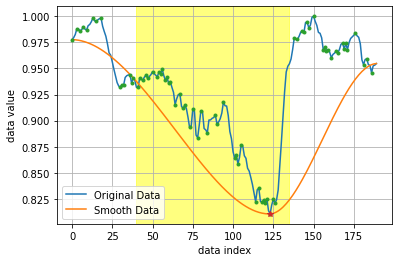

###########Print All Extremas#################
[(51, 0.00013394027926527663), (52, 0.00013394027926527663), (42, 0.003993518656560391), (49, 0.003993518656560391), (189, 0.03902095231059144), (150, 0.03902095231059144), (0, 0.02107910149464043), (9, 0.02107910149464043), (116, inf)]
###########Print Filtered Extremas#################
[116]
###########Print Sorted Extremas#################
[(0, 0.02107910149464043), (9, 0.02107910149464043), (42, 0.003993518656560391), (49, 0.003993518656560391), (51, 0.00013394027926527663), (52, 0.00013394027926527663), (116, inf), (150, 0.03902095231059144), (189, 0.03902095231059144)]
###########Print Minimas#################
[(0, 0.02107910149464043), (42, 0.003993518656560391), (51, 0.00013394027926527663), (116, inf), (189, 0.03902095231059144)]
###########Print Maximas#################
[(9, 0.02107910149464043), (49, 0.003993518656560391), (52, 0.00013394027926527663), (150, 0.03902095231059144)]


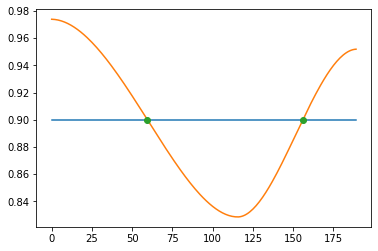

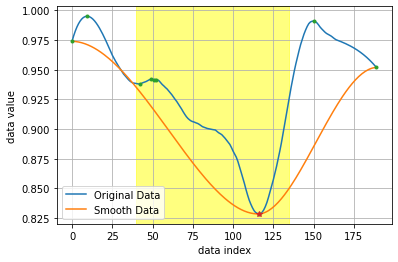

BGS show


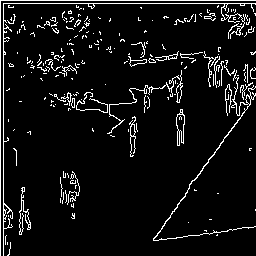

Test case loaded
Test026 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(172, 0.0023604653832185463), (173, 0.0023604653832185463), (179, 0.0042696322665125575), (178, 0.0042696322665125575), (175, 0.029697129507646802), (181, 0.029697129507646802), (170, 0.0005969435764366926), (171, 0.0005969435764366926), (88, 0.009287855192482875), (87, 0.009287855192482875), (94, 0.0066212450596876415), (93, 0.0066212450596876415), (162, 0.000533841069441432), (163, 0.000533841069441432), (101, 0.0018084097560525647), (100, 0.0018084097560525647), (104, 0.004664370426203157), (103, 0.004664370426203157), (107, 0.007967165328108261), (105, 0.007967165328108261), (110, 0.0069260015581171785), (109, 0.0069260015581171785), (134, 0.0050817173472840205), (133, 0.0050817173472840205), (150, 0.023923766347085595), (156, 0.023923766347085595), (114, 0.0008630706462866566), (113, 0.0008630706462866566), (118, 0.011042231022274085), (115, 0.

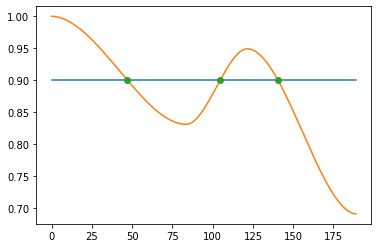

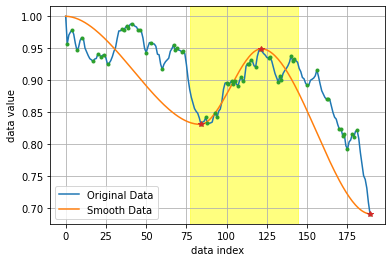

###########Print All Extremas#################
[(91, 0.0799084524868866), (127, 0.0799084524868866), (16, 0.03627135830856276), (40, 0.03627135830856276), (189, inf)]
###########Print Filtered Extremas#################
[189]
###########Print Sorted Extremas#################
[(16, 0.03627135830856276), (40, 0.03627135830856276), (91, 0.0799084524868866), (127, 0.0799084524868866), (189, inf)]
###########Print Minimas#################
[(16, 0.03627135830856276), (91, 0.0799084524868866), (189, inf)]
###########Print Maximas#################
[(40, 0.03627135830856276), (127, 0.0799084524868866)]


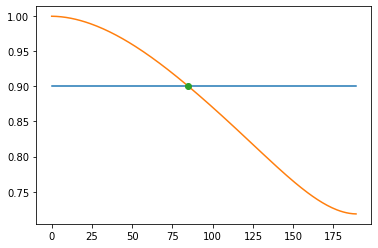

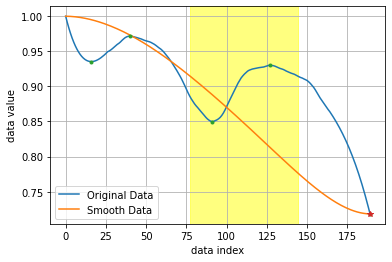

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(86, 0.004571307365286437), (87, 0.004571307365286437), (94, 0.00018542577088309642), (93, 0.00018542577088309642), (178, 0.0207571025255342), (181, 0.0207571025255342), (96, 0.005074140384071835), (95, 0.005074140384071835), (81, 0.00518174747057909), (83, 0.00518174747057909), (172, 0.0018452685678437275), (173, 0.0018452685678437275), (77, 0.0010259065687999724), (78, 0.0010259065687999724), (72, 0.0018372867101159596), (74, 0.0018372867101159596), (162, 0.000348999909690062), (161, 0.000348999909690062), (104, 0.004684805986604257), (103, 0.004684805986604257), (136, 0.0010515415516433313), (135, 0.0010515415516433313), (63, 0.002329847031892429), (62, 0.002329847031892429), (160, 0.01612022661884549), (164, 0.01612022661884549), (17, 0.0036834613414780115), (16, 0.0036834613414780115), (139, 0.0027269492399494277), (138, 0.0027269492399494277), (150, 0.024247306089036802), (156, 0.

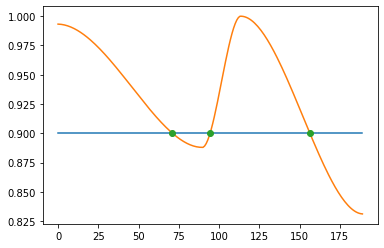

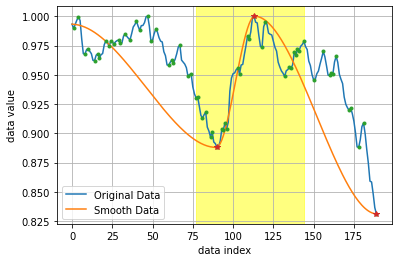

###########Print All Extremas#################
[(144, 0.003402488828719963), (153, 0.003402488828719963), (89, 0.07591811361061962), (116, 0.07591811361061962), (16, 0.02095729979380423), (39, 0.02095729979380423), (189, inf)]
###########Print Filtered Extremas#################
[189]
###########Print Sorted Extremas#################
[(16, 0.02095729979380423), (39, 0.02095729979380423), (89, 0.07591811361061962), (116, 0.07591811361061962), (144, 0.003402488828719963), (153, 0.003402488828719963), (189, inf)]
###########Print Minimas#################
[(16, 0.02095729979380423), (89, 0.07591811361061962), (144, 0.003402488828719963), (189, inf)]
###########Print Maximas#################
[(39, 0.02095729979380423), (116, 0.07591811361061962), (153, 0.003402488828719963)]


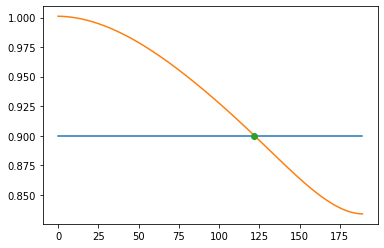

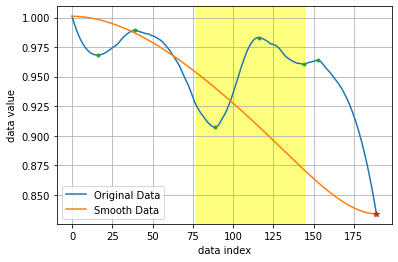

BGS show


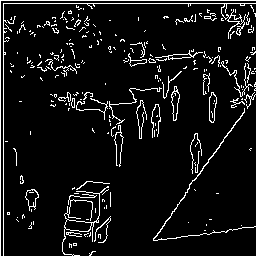

Test case loaded
Test027 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(101, 0.014603746730573408), (100, 0.014603746730573408), (103, 0.02003859853662726), (102, 0.02003859853662726), (92, 0.0023380806908626095), (93, 0.0023380806908626095), (105, 0.0012733964719201518), (104, 0.0012733964719201518), (95, 0.04423062131748412), (98, 0.04423062131748412), (90, 0.014437644767621993), (91, 0.014437644767621993), (87, 0.012470197273680594), (88, 0.012470197273680594), (83, 0.018607700720444376), (84, 0.018607700720444376), (110, 0.03126985894764145), (109, 0.03126985894764145), (108, 0.07968315755254374), (107, 0.07968315755254374), (67, 0.009359467455359649), (68, 0.009359467455359649), (78, 0.022281043731792294), (80, 0.022281043731792294), (74, 0.023450181680080062), (73, 0.023450181680080062), (70, 0.04315155661029446), (76, 0.04315155661029446), (54, 0.0007899480302565598), (53, 0.0007899480302565598), (47, 0.01467818

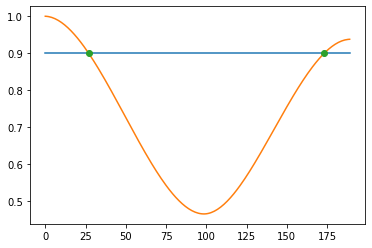

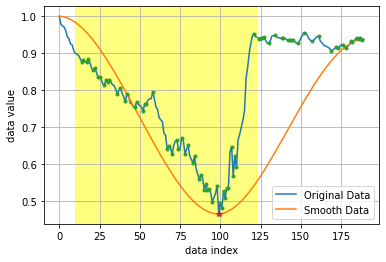

###########Print All Extremas#################
[(174, 0.04329059014014347), (135, 0.04329059014014347), (96, inf)]
###########Print Filtered Extremas#################
[96]
###########Print Sorted Extremas#################
[(96, inf), (135, 0.04329059014014347), (174, 0.04329059014014347)]
###########Print Minimas#################
[(96, inf), (174, 0.04329059014014347)]
###########Print Maximas#################
[(135, 0.04329059014014347)]


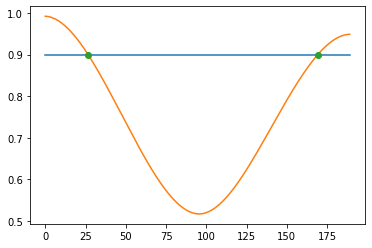

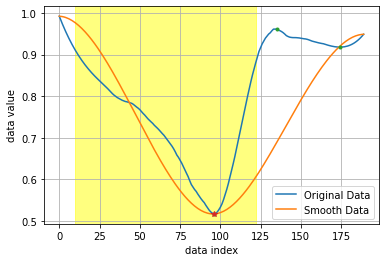

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(105, 0.008638253606234048), (104, 0.008638253606234048), (101, 0.02594489800301858), (100, 0.02594489800301858), (99, 0.03109227702992523), (102, 0.03109227702992523), (95, 0.04692303115172536), (98, 0.04692303115172536), (90, 0.0068411216763546445), (91, 0.0068411216763546445), (110, 0.02338960993822481), (109, 0.02338960993822481), (108, 0.07334434778691956), (107, 0.07334434778691956), (87, 0.016141739461063453), (88, 0.016141739461063453), (83, 0.016188509924547123), (84, 0.016188509924547123), (78, 0.007863172156406861), (80, 0.007863172156406861), (75, 0.0188101246756468), (76, 0.0188101246756468), (70, 0.012471720124963781), (72, 0.012471720124963781), (65, 0.005467867408731619), (66, 0.005467867408731619), (54, 0.0022956562091401844), (53, 0.0022956562091401844), (49, 0.0006807941287646502), (48, 0.0006807941287646502), (47, 0.007325763908386129), (50, 0.007325763908386129), (5

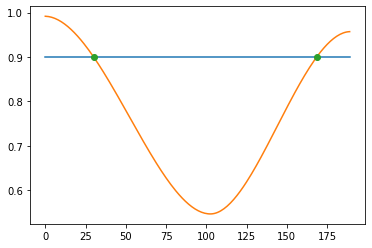

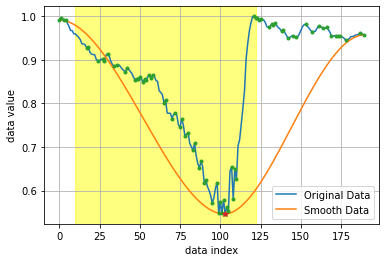

###########Print All Extremas#################
[(159, 7.32597915260591e-05), (160, 7.32597915260591e-05), (145, 0.0019315799615977625), (154, 0.0019315799615977625), (181, 0.04675865765069642), (133, 0.04675865765069642), (97, inf)]
###########Print Filtered Extremas#################
[97]
###########Print Sorted Extremas#################
[(97, inf), (133, 0.04675865765069642), (145, 0.0019315799615977625), (154, 0.0019315799615977625), (159, 7.32597915260591e-05), (160, 7.32597915260591e-05), (181, 0.04675865765069642)]
###########Print Minimas#################
[(97, inf), (145, 0.0019315799615977625), (159, 7.32597915260591e-05), (181, 0.04675865765069642)]
###########Print Maximas#################
[(133, 0.04675865765069642), (154, 0.0019315799615977625), (160, 7.32597915260591e-05)]


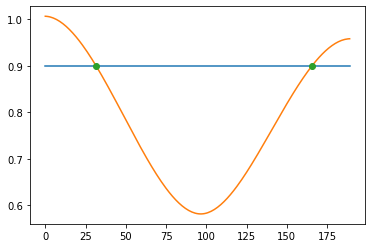

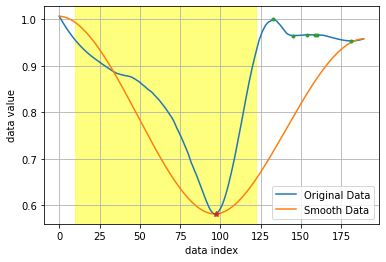

BGS show


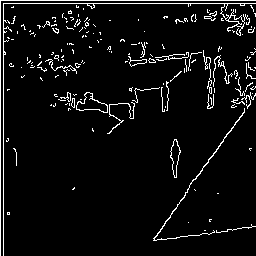

Test case loaded
Test028 data set loaded
==============With BG Masked==============
(190,)
###########Print All Extremas#################
[(49, 0.00111430640013932), (50, 0.00111430640013932), (181, 0.00017451356394038164), (180, 0.00017451356394038164), (9, 0.01668466967207638), (6, 0.01668466967207638), (184, 0.0046085945833904685), (183, 0.0046085945833904685), (189, 0.01695335499271533), (186, 0.01695335499271533), (13, 0.0029472951334602593), (12, 0.0029472951334602593), (111, 0.0303370863584278), (116, 0.0303370863584278), (168, 0.009297467597450426), (167, 0.009297467597450426), (159, 0.011904747992289466), (160, 0.011904747992289466), (163, 0.05603092238294127), (171, 0.05603092238294127), (18, 0.00014510886873730922), (17, 0.00014510886873730922), (27, 0.00037360065349212324), (28, 0.00037360065349212324), (138, 0.014904275441937176), (141, 0.014904275441937176), (148, 0.08750966945389693), (155, 0.08750966945389693), (74, 0.0036657789210665648), (73, 0.0036657789210665648), (

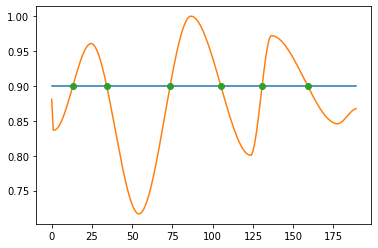

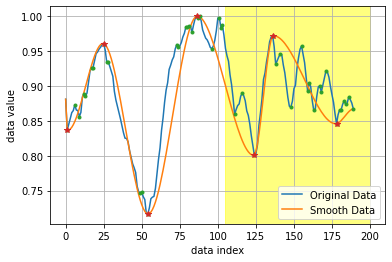

###########Print All Extremas#################
[(0, 0.10209600935003726), (21, 0.10209600935003726), (120, 0.058172210499781496), (146, 0.058172210499781496), (189, 0.1289166923357704), (87, 0.1289166923357704), (50, inf)]
###########Print Filtered Extremas#################
[0, 21, 50, 87, 189]
###########Print Sorted Extremas#################
[(0, 0.10209600935003726), (21, 0.10209600935003726), (50, inf), (87, 0.1289166923357704), (120, 0.058172210499781496), (146, 0.058172210499781496), (189, 0.1289166923357704)]
###########Print Minimas#################
[(0, 0.10209600935003726), (50, inf), (120, 0.058172210499781496), (189, 0.1289166923357704)]
###########Print Maximas#################
[(21, 0.10209600935003726), (87, 0.1289166923357704), (146, 0.058172210499781496)]


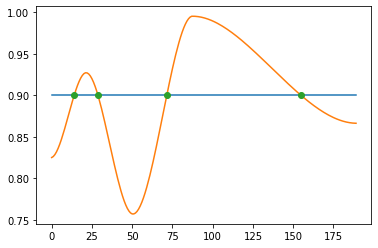

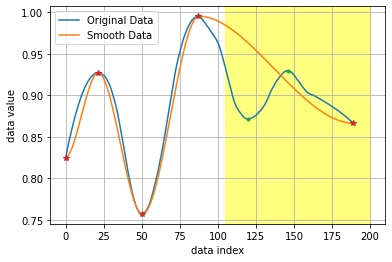

==============Without BG Masked==============
(190,)
###########Print All Extremas#################
[(1, 0.010747885991635564), (5, 0.010747885991635564), (12, 0.0030586050994073632), (11, 0.0030586050994073632), (36, 0.0019894324725818757), (37, 0.0019894324725818757), (47, 0.004152695301395504), (50, 0.004152695301395504), (39, 0.014808641503314846), (44, 0.014808641503314846), (27, 0.003708419711281774), (28, 0.003708419711281774), (24, 0.0020143599298235726), (25, 0.0020143599298235726), (55, 0.0326281510016283), (23, 0.0326281510016283), (65, 0.00012390362998282445), (64, 0.00012390362998282445), (189, 0.002054933106979129), (186, 0.002054933106979129), (181, 0.003135931077996923), (180, 0.003135931077996923), (178, 0.008384725807584759), (183, 0.008384725807584759), (71, 0.0019505878840631041), (70, 0.0019505878840631041), (111, 0.028564965864106062), (117, 0.028564965864106062), (78, 0.00264083937747539), (77, 0.00264083937747539), (151, 0.0032329500682760637), (150, 0.003232950

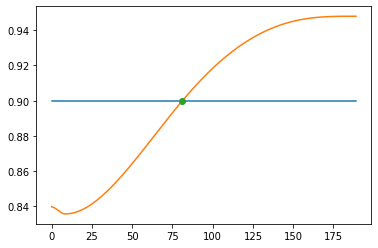

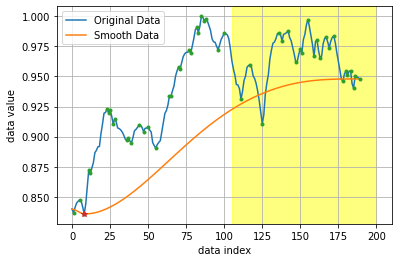

###########Print All Extremas#################
[(46, 0.014291962713103401), (32, 0.014291962713103401), (118, 0.038974695400190384), (149, 0.038974695400190384), (189, 0.05140634412646439), (87, 0.05140634412646439), (0, inf)]
###########Print Filtered Extremas#################
[0]
###########Print Sorted Extremas#################
[(0, inf), (32, 0.014291962713103401), (46, 0.014291962713103401), (87, 0.05140634412646439), (118, 0.038974695400190384), (149, 0.038974695400190384), (189, 0.05140634412646439)]
###########Print Minimas#################
[(0, inf), (46, 0.014291962713103401), (118, 0.038974695400190384), (189, 0.05140634412646439)]
###########Print Maximas#################
[(32, 0.014291962713103401), (87, 0.05140634412646439), (149, 0.038974695400190384)]


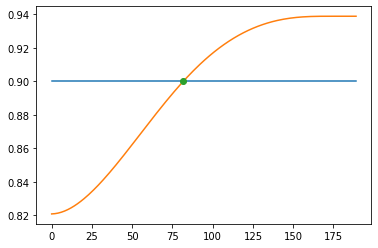

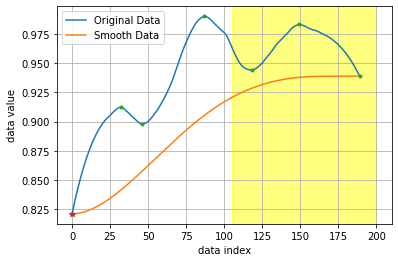

KeyboardInterrupt: ignored

In [34]:
def build_model_aae():
  
    model_enc = load_model(conf.cwdir+"/model_gen_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    model_dec = load_model(conf.cwdir+"/model_dec_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    model_disc = load_model(conf.cwdir+"/model_dis_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})

    #model_enc = load_model("/content/drive/My Drive/model_gen_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    #model_dec = load_model("/content/drive/My Drive/model_dec_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    #model_disc = load_model("/content/drive/My Drive/model_dis_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})

    model_ae = Sequential()
    model_ae.add(model_enc)
    model_ae.add(model_dec)
    
    model_enc_disc = Sequential()
    model_enc_disc.add(model_enc)
    model_enc_disc.add(model_disc)
    
    return model_enc, model_dec, model_disc, model_ae, model_enc_disc

model_enc, model_dec, model_disc, model_ae, model_enc_disc = build_model_aae()

model_enc.summary()
model_dec.summary()
model_disc.summary()
model_ae.summary()
model_enc_disc.summary()

model_disc.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
model_enc_disc.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
model_ae.compile(optimizer=Adam(lr=1e-4, decay=1e-5, epsilon=1e-6), loss="mse")
#"/content/drive/My Drive/UCSD_Anomaly_Dataset.v1p2/model.hdf5"

#model_ae = load_model("/content/drive/My Drive/VAE/model1.hdf5",custom_objects={'LayerNormalization': LayerNormalization})

def evaluate_dis(sequences, model, id, dt):
    fooling_loss = model.predict(sequences,batch_size=conf.BATCH_SIZE)
    sa = (fooling_loss - np.min(fooling_loss)) / (np.max(fooling_loss))
    sr = 1.0 - sa

    with open(join("/content/drive/My Drive/", 'sr_score.csv'), mode='a') as f:
        writer = csv.writer(f)
        writer.writerow([float(x[0]) for x in sr])
        f.close()

    threshold_abs = threshold# np.min(sr)+ (np.max(sr) - np.min(sr)) * threshold
    if dt == 1:
        fill_gt_ped1(sr, id, 'red', threshold_abs)
    elif dt == 2:
        fill_gt_ped2(sr, id, 'red', threshold_abs)
    #plt.plot(sr)
    #plt.ylabel('regularity score sr_dis(t)')
    #plt.xlabel('frame t')
    #plt.show()

def get_clips(test):
    sz = test.shape[0] - conf.dim1
    sequences = np.zeros((sz, conf.dim1, conf.dim2, conf.dim3))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim1, conf.dim2, conf.dim3))
        for j in range(0, conf.dim1):
            clip[j] = test[i + j, :, :]
        sequences[i] = clip
    return sequences


def mask_array(bg_list):

    for p in range(0, bg_list.shape[0]):
        for r in range(256):
            for c in range(256):
                if bg_list[p][r][c] > 0:
                    bg_list[p][r][c] = 1
                else:
                    bg_list[p][r][c] = 0

    bg_list[0, :, :] = 0
    return bg_list

def evaluate_ae(sequences, model, id, dt, bg_list=[], mask=1):
  
    sz = len(sequences)

    reconstructed_sequences = model.predict(sequences,batch_size=conf.BATCH_SIZE)
    #print(bg_list[10])

    masked_bg = mask_array(bg_list)
    bg_clips = get_clips(masked_bg)

    sequences = np.reshape(sequences, (sequences.shape[0], sequences.shape[1], sequences.shape[2], sequences.shape[3]))
    reconstructed_sequences = np.reshape(reconstructed_sequences, (reconstructed_sequences.shape[0], reconstructed_sequences.shape[1], reconstructed_sequences.shape[2], reconstructed_sequences.shape[3]))

    if mask == 1:
        print("==============With BG Masked==============")
        sq_masked = np.multiply(sequences, bg_clips)
        rec_masked = np.multiply(reconstructed_sequences, bg_clips)
    else:
        print("==============Without BG Masked==============")
        sq_masked = sequences
        rec_masked = reconstructed_sequences

    #bg_weights = np.add(np.ones(bg_clips.shape), bg_clips)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sq_masked[i], rec_masked[i])) for i in range(0,sz)])
    #sequences_reconstruction_cost = np.array([np.linalg.norm(np.multiply(bg_weights[i],np.subtract(sequences[i], reconstructed_sequences[i]))) for i in range(0,sz)])


    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / (np.max(sequences_reconstruction_cost))

    
    sr = 1 - sa
    threshold_abs = threshold#np.min(sr)+ (np.max(sr) - np.min(sr)) * threshold
    if dt == 1:
        fill_gt_ped1(sr, id, 'yellow', threshold_abs)
    elif dt == 2:
        fill_gt_ped2(sr, id, 'yellow', threshold_abs)
    #plt.plot(sr)
    #plt.ylabel('regularity score sr_ae(t)')
    #plt.xlabel('frame t')
    #plt.show()
    

def load_input_data_list():
    path = join("/content/drive/My Drive/", 'sr_score.csv')
    InputDataList = LoadData(path)
    return InputDataList


def get_persistance(InputData):
  #~ This simple call is all you need to compute the extrema of the given data and their persistence.
  ExtremaAndPersistence = RunPersistence(InputData)

  #~ Keep only those extrema with a persistence larger than 10.
  Filtered = [t for t in ExtremaAndPersistence if ExtremaAndPersistence[1] > 50]
  print(ExtremaAndPersistence)
  print(Filtered)
  #~ Sort the list of extrema by persistence.
  #Sorted = sorted(Filtered, key=lambda ExtremumAndPersistence: ExtremumAndPersistence[1])

  return Filtered


conf.reconfig(new_name="Conv2DLSTM_AAE_PED1", batch_size=4, epochs=100, retrain=1)




def edge_detect(gray):
    edges1 = np.uint8(gray)
    # Using the Canny filter to get contours
    #edges = cv2.Canny(edges1, 20, 30)
    
    # Using the Canny filter with different parameters
    edges_high_thresh = cv2.Canny(edges1, 160, 200)
    kernel = np.zeros((3,3),np.uint8)
    images = cv2.morphologyEx(edges_high_thresh, cv2.MORPH_OPEN, kernel)
    images = cv2.morphologyEx(edges_high_thresh, cv2.MORPH_OPEN, kernel)
    images = cv2.morphologyEx(images, cv2.MORPH_CLOSE, kernel)
    # Stacking the images to print them together
    # For comparison
    #images = np.hstack((gray, edges, edges_high_thresh))

    #kernel = np.ones((3,3), np.uint8) 
    #fg_mask = cv2.erode(edges_high_thresh, kernel, iterations=2)
    # Display the resulting frame
    #cv2_imshow(images)
    return images

    
def get_background_subtr(test_case):
    print("BGS show")
    subtractor = cv2.createBackgroundSubtractorMOG2(history=20, varThreshold=50, detectShadows=True)
    bg_list = []
    for frame in test_case:
        frame = np.reshape(frame, (256, 256))*256
        edge_mask = edge_detect(frame)

        #edge_mask = subtractor.apply(edge_mask)
        #edge_mask[0] = np.zeros(edge_mask[0].shape)
        #kernel = np.ones((5,5), np.uint8) 
        #fg_mask = cv2.erode(mask, kernel, iterations=2)
        #fg_mask = cv2.dilate(fg_mask, kernel, iterations=5)
        fg_mask = edge_mask/255.0
        #fg_mask = mask
        #cv2_imshow(fg_mask)
        #print(fg_mask)
        bg_list.append(fg_mask)
        #key = cv2.waitKey(30)
        #if key == 27:
        #    break
    cv2_imshow(bg_list[100]*255.0)
    #cv2.destroyAllWindows()
    #print(bg_list)
    return np.array(bg_list)


def show_bgs(test_case_dir):
    test = get_single_test(join(conf.TEST_DIR,test_case_dir))
    return get_background_subtr(test)



#print(bg_list[10])
for i in range(1,37):
  if i < 10:
    img_num = "00"+str(i)
  elif i < 100:
    img_num = "0"+str(i)
  else:
    img_num = str(i) 

  #if img_num == "017":
  #  continue

  bg_list = show_bgs("Test"+img_num)
  
  
  test_cases_dir = "Test"+img_num
  test_cases = get_test_sequences(test_cases_dir)
  print("Test"+img_num+" data set loaded")
  #evaluate_dis(test_cases, model_enc_disc, i, 1)
  #sorted_sr = get_persistance(np.array([x[0] for x in sr_dis], dtype=float))
  #print(sorted_sr)
  #break
  evaluate_ae(test_cases, model_ae, i, 1, bg_list, 1)
  evaluate_ae(test_cases, model_ae, i, 1, bg_list, 0)
  #sr_comb = (sr_dis + sr_ae)*0.5
  #sr_comb = []

  continue
 